In [108]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import constants as cst
from astropy import units as u
import healpy as hp

from aqn import *
from constants import *
from survey_parameters import *
from skymap_plotting_functions import *
from aqn_simulation import *

import sys
sys.path.append('../analysis')

from mcmc_models import *

# Standalone functions

In [109]:
def generate_cylinder_filters(n):
    # Define radii
    s_inner = 7.8
    s_outer = 9.2
    
    # Angular range for each slice
    delta_theta = 2 * np.pi / n
    
    filters = []
    
    for i in range(n):
        theta_min = i * delta_theta
        theta_max = (i + 1) * delta_theta
        filters.append(np.where((s[within_cylinder] >= s_inner) & (s[within_cylinder] <= s_outer) & 
                                (theta[within_cylinder] >= theta_min) & (theta[within_cylinder] < theta_max) & 
                                (np.abs(z[within_cylinder]) < 1.2)))
    return filters

In [110]:
def fix_grid_coords_rotation(grid_coords):

    # these are the correct ones from the binned histogram notebook
    
    ############### Rotation 1 ####################
    theta = np.radians(11)  # Convert angle to radians
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, cos_theta, -sin_theta],
        [0, sin_theta, cos_theta]
    ])
    
    grid_coords = grid_coords @ rotation_matrix.T
    ###############################################
    
    ############### Rotation 2 ####################
    theta = np.radians(30)  # Convert angle to radians
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, 0, -sin_theta],
        [0, 1, 0],
        [sin_theta, 0, cos_theta]
    ])
    
    grid_coords = grid_coords @ rotation_matrix.T
    ###############################################

    return grid_coords

In [111]:
def fix_grid_coords_rotation(grid_coords):
    ############### Rotation 1 ####################
    theta = np.radians(30)  # Convert angle to radians
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, cos_theta, -sin_theta],
        [0, sin_theta, cos_theta]
    ])
    
    grid_coords = grid_coords @ rotation_matrix.T
    ###############################################
    ############### Rotation 2 ####################
    theta = np.radians(11)  # Convert angle to radians
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, 0, -sin_theta],
        [0, 1, 0],
        [sin_theta, 0, cos_theta]
    ])
    
    grid_coords = grid_coords @ rotation_matrix.T
    ###############################################

    return grid_coords

In [112]:
def compute_f_aqn(cubes, m_aqn_kg):

    R_aqn_cm = calc_R_AQN(m_aqn_kg)
    
    # cubes["dark_mat"] = (cubes["dark_mat"] / m_aqn_kg).to(1/u.cm**3)
    
    # compute T_AQN
    cubes["t_aqn_n"] = T_AQN_analytical(cubes["neut_gas"], cubes["dv_neut"], f, g)
    cubes["t_aqn_i"] = T_AQN_ionized2(  cubes["ioni_gas"], cubes["dv_ioni"], f, g, 
                                        cubes["temp_ion"], R_aqn_cm)
    # if ioni temp is lower than neut temp, replace with neut temp
    cubes["t_aqn_i"][cubes["t_aqn_i"]<cubes["t_aqn_n"]] = \
    cubes["t_aqn_n"][cubes["t_aqn_i"]<cubes["t_aqn_n"]]
    
    # from erg/s/Hz/cm2 to photons/s/A/cm2
    skymap_units =  1*u.photon / u.cm**2 / u.s / u.Angstrom
    def to_skymap_units(F_erg_hz_cm2,nu):
        erg_hz_cm2 = 1*u.erg/u.s/u.Hz/u.cm**2
        w = nu.to(u.AA, equivalencies=u.spectral())
        C = (erg_hz_cm2).to(skymap_units, u.spectral_density(w))
        return F_erg_hz_cm2 * C / erg_hz_cm2 * 2*np.pi

    cubes["aqn_emit"] = np.zeros(np.shape(cubes["t_aqn_n"])) * skymap_units / u.sr
    
    for nu in frequency_band:
        cubes["aqn_emit"] += to_skymap_units(spectral_surface_emissivity(nu, 
                           cubes["t_aqn_n"])/(dOmega*u.sr)*dnu/nu_range, nu) + \
                             to_skymap_units(spectral_surface_emissivity(nu, 
                           cubes["t_aqn_i"])/(dOmega*u.sr)*dnu/nu_range, nu)

    cubes["aqn_emit"] = cubes["aqn_emit"] * 4 * np.pi * R_aqn_cm**2 * \
                       (cubes["dark_mat"] / m_aqn_kg).to(1/u.cm**3)

    return cubes["aqn_emit"]

In [207]:
def import_cubes(reference=False, location="../data/FIRE/"):
    grid_coords = np.load("../data/FIRE/grid-coords.npy") # !!! these are now rotated!

    cubes = {}
    
    cubes["aqn_emit"] = np.load(location + "cubes/cube-aqn_emit.npy") * u.photon / u.cm**3 / u.s / u.Angstrom / u.sr
    cubes["dark_mat"] = np.load(location + "cubes/cube-dark_mat_density.npy") * u.kg/u.m**3 * 2/5
    cubes["ioni_gas"] = np.load(location + "cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
    cubes["neut_gas"] = np.load(location + "cubes/cube-neut_gas_density.npy") * u.kg/u.m**3
    cubes["temp_ion"] = np.load(location + "cubes/cube-ioni_gas_temp.npy") * u.K
    cubes["dv_ioni"]  = np.load(location + "cubes/cube-dv_ioni.npy") * u.m/u.s
    cubes["dv_neut"]  = np.load(location + "cubes/cube-dv_neut.npy") * u.m/u.s
    
    # perform some unit conversions
    cubes["ioni_gas"] = (cubes["ioni_gas"]/cst.m_p.si).to(1/u.cm**3)
    cubes["neut_gas"] = (cubes["neut_gas"]/cst.m_p.si).to(1/u.cm**3)
    cubes["dark_mat"] = (cubes["dark_mat"]) # /  m_aqn_kg).to(1/u.cm**3) # done in code
    cubes["temp_ion"] =  cubes["temp_ion"]*K_to_eV
    cubes["dv_ioni"]  =  cubes["dv_ioni"] /cst.c
    cubes["dv_neut"]  =  cubes["dv_neut"] /cst.c
    cubes["temp_ion"] = cubes["temp_ion"] + \
                        1/2 * (938*u.MeV).to(u.eV) * cubes["dv_ioni"]**2
    
    if reference:
        cubes["dark_mat_ref"] = np.load(location + "cubes/cube-dark_mat_density.npy") * u.kg/u.m**3 * 2/5
        cubes["ioni_gas_ref"] = np.load(location + "cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
        cubes["neut_gas_ref"] = np.load(location + "cubes/cube-neut_gas_density.npy") * u.kg/u.m**3

        # cubes["ioni_gas_ref"] = (cubes["ioni_gas_ref"]/cst.m_p.si).to(1/u.cm**3)
        # cubes["neut_gas_ref"] = (cubes["neut_gas_ref"]/cst.m_p.si).to(1/u.cm**3)
        # cubes["dark_mat_ref"] = (cubes["dark_mat_ref"]) # /  m_aqn_kg).to(1/u.cm**3) # done in code

        
    return grid_coords, cubes

In [188]:
def plot_demo_cylinder_filters():
    plt.figure(figsize=(10,10), dpi=50)
    for i in range(2):
        plt.scatter(x[within_cylinder][filters[i]], y[within_cylinder][filters[i]], label=str(i))
    plt.legend()
    plt.show()

In [8]:
def plot_cube_2(ax, quant, grid_coords):
    z_min, z_max = -2, 2
    grid_size = 100
    
    # Filter particles within the z range
    z_coords = grid_coords[:, 2]
    z_mask = (z_coords >= z_min) & (z_coords <= z_max)
    
    # Select the particles and densities within this range
    filtered_coords = grid_coords[z_mask]
    
    filtered_densities = np.reshape(quant, (512**3))[z_mask].value
    
    # Project onto the x-y plane
    x_coords = filtered_coords[:, 0]
    y_coords = filtered_coords[:, 1]
    
    # Create a 2D histogram to count the number of points in each bin (density map)
    count_hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=grid_size)
    
    # Create a 2D histogram weighted by the densities
    weighted_hist, _, _ = np.histogram2d(x_coords, y_coords, bins=grid_size, weights=filtered_densities)
    
    # Normalize by the number of points in each bin to get the average density
    with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
        normalized_hist = np.divide(weighted_hist, count_hist)
        normalized_hist[np.isnan(normalized_hist)] = 0  # Replace NaNs with zeros (where there are no points)
    
    # Plot the normalized 2D histogram
    ax.imshow(normalized_hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # ax.set_colorbar(label='')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Projection in X-Y Plane, Z ∈ [-2,2] kpc')


In [9]:
def plot_slice_outlines(ax, n, title):
    r_outer = 9.2
    r_inner = 7.8
    
    colors_list = [plt.cm.ocean(i / n) for i in range(16)]
    
    ax.set_title(title)
    ax.set_aspect('equal', 'box')  # Keep the aspect ratio square
    ax.set_xlim(-r_outer-1, r_outer+1)
    ax.set_ylim(-r_outer-1, r_outer+1)
    
    # Plot each slice's outline
    for i in range(n):
        # Angular range for this slice
        th_min = i * 2 * np.pi / n
        th_max = (i + 1) * 2 * np.pi / n
        
        # Generate the points for the outer and inner arcs
        th = np.linspace(th_min, th_max, 100)
        x_outer = r_outer * np.cos(th)
        y_outer = r_outer * np.sin(th)
        x_inner = r_inner * np.cos(th)
        y_inner = r_inner * np.sin(th)
        
        # Plot the outer and inner arcs
        ax.plot(x_outer, y_outer, color=colors_list[i], lw=2)
        ax.plot(x_inner, y_inner, color=colors_list[i], lw=2)
        
        # Optionally, connect the outer and inner arcs to form the slice boundary
        ax.plot([x_outer[0], x_inner[0]], [y_outer[0], y_inner[0]], color=colors_list[i], lw=2)
        ax.plot([x_outer[-1], x_inner[-1]], [y_outer[-1], y_inner[-1]], color=colors_list[i], lw=2)

# Import cubes and filter out the donut to sample from

In [10]:
# define cube resolution parameters
cube_length       = 20   # kpc # 20 for radio
voxel_resolution  = 2**9 # bins / kpc

In [11]:
# define AQN parameters
m_aqn_kg = 0.3*u.kg
R_aqn_cm = calc_R_AQN(m_aqn_kg)

print("using m_aqn =", m_aqn_kg)
print("using R_aqn =", R_aqn_cm)

# specify frequency resolution and create frequency band array
# Change frequency range within survey_parameters.py
dnu = 1e14*u.Hz # 1e9 for WMAP, 1e14 for GALEX
frequency_band = np.arange(f_min_hz.value, f_max_hz.value, dnu.value) * u.Hz
nu_range = f_max_hz - f_min_hz

# This is only added for the /sr dependence of the units
dOmega = 1

using m_aqn = 0.3 kg
using R_aqn = 5.892797722880519e-05 cm


In [12]:
# import cubes and grid_coords
# add -uv to all of these to target UV cube
# grid_coords = np.load("../data/FIRE/grid-coords.npy")
# grid_ids = np.load("../data/FIRE/grid-ids---dark_mat-uv.npy")

grid_coords, cubes = import_cubes()

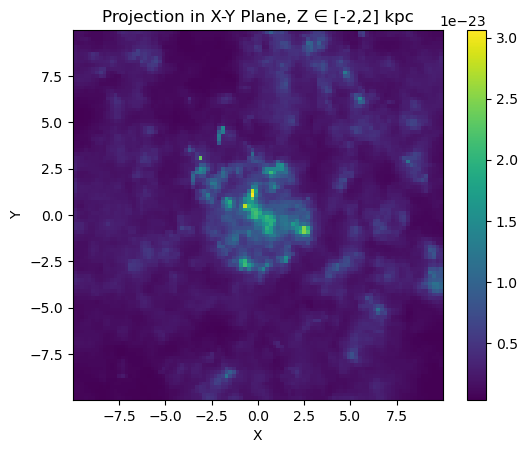

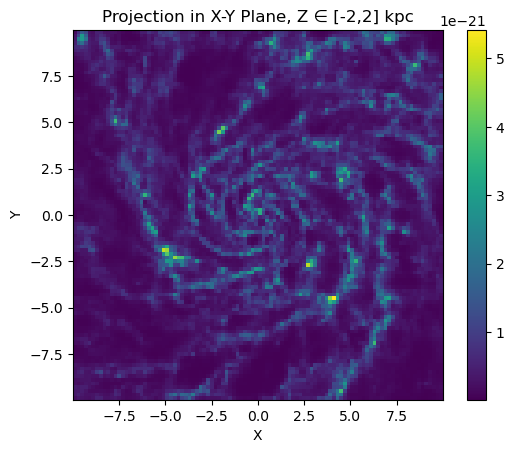

In [114]:
# np.load("../data/FIRE/cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
visualize_sum_along_axis_2(np.load("/arc/projects/unions/lensing/msekatchev/cube-ioni_gas_density.npy")*u.K, grid_coords)
visualize_sum_along_axis_2(np.load("/arc/projects/unions/lensing/msekatchev/cube-neut_gas_density.npy")*u.K, grid_coords)


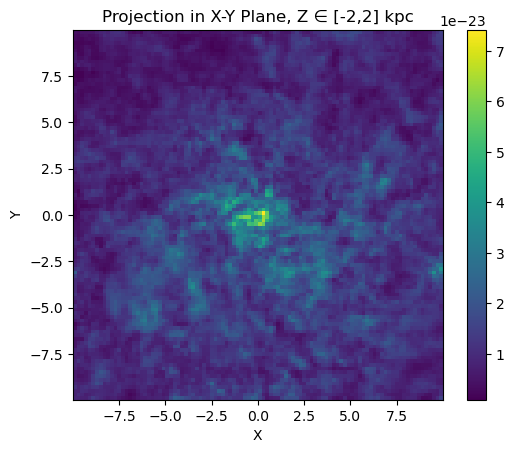

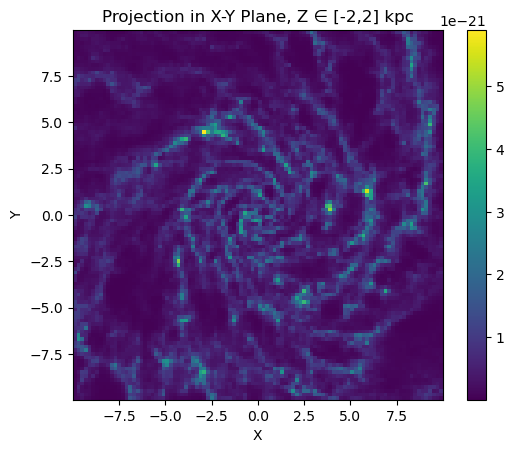

In [107]:
visualize_sum_along_axis_2(np.load("../data/FIRE/cubes/cube-ioni_gas_density.npy") * u.K, grid_coords)
visualize_sum_along_axis_2(np.load("../data/FIRE/cubes/cube-neut_gas_density.npy") * u.K, grid_coords)

In [17]:
s, x, y, z = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2), grid_coords[:,0], grid_coords[:,1], grid_coords[:,2]
r = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2 + grid_coords[:,2]**2)
theta = np.arctan2(y, x)  # Angle in radians [-π, π]
theta = np.where(theta < 0, theta + 2 * np.pi, theta)  # Normalize to [0, 2π]

In [19]:
within_cylinder = np.where((s  <  9.2) &
                           (s  >  6.8) &
                           (z  <  1.2) & 
                           (z  > -1.2))  

emissivity_cylinder = np.reshape(cubes["aqn_emit"], voxel_resolution**3)[within_cylinder]

# np.save("../data/emissivity_uv.npy", emissivity_cylinder.value)

In [20]:
# reshape cubes to only within the cylinder
for quant in cubes:
    cubes[quant] = np.reshape(cubes[quant], voxel_resolution**3)[within_cylinder]

# Alternatively, calculate emissivity cube

In [29]:
cubes["aqn_emit"] = compute_f_aqn(cubes, m_aqn_kg)
np.save("../data/FIRE/cubes/cubes-aqn_emit.npy", cubes["aqn_emit"].value)

In [127]:
m_aqn_kg = 0.03 * u.kg

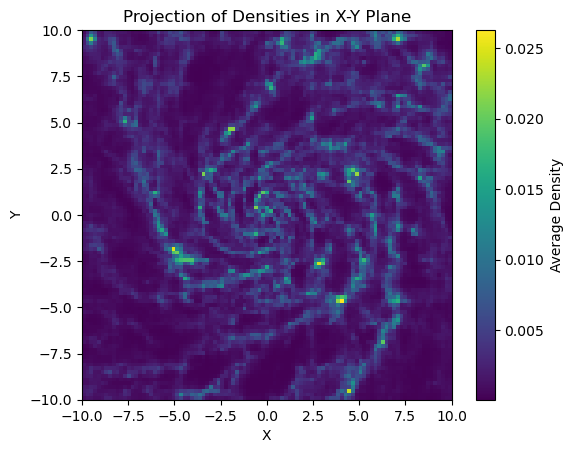

In [48]:
z_min, z_max = -5, 5
grid_size = 100

# Filter particles within the z range
z_coords = grid_coords[:, 2]
z_mask = (z_coords >= z_min) & (z_coords <= z_max)

# Select the particles and densities within this range
filtered_coords = grid_coords[z_mask]
quant = cubes["neut_gas"]

filtered_densities = np.reshape(quant, (512**3))[z_mask].value

# Project onto the x-y plane
x_coords = filtered_coords[:, 0]
y_coords = filtered_coords[:, 1]

# Create a 2D histogram with the specified grid size
hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=np.linspace(-10,10, 100), 
                                      weights=filtered_densities, 
                                      density=True)

# # Create a 2D histogram to count the number of points in each bin (density map)
# count_hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=grid_size)

# # Create a 2D histogram weighted by the densities
# weighted_hist, _, _ = np.histogram2d(x_coords, y_coords, bins=grid_size, weights=filtered_densities)

# # Normalize by the number of points in each bin to get the average density
# with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
#     normalized_hist = np.divide(weighted_hist, count_hist)
#     normalized_hist[np.isnan(normalized_hist)] = 0  # Replace NaNs with zeros (where there are no points)

# Plot the 2D histogram
plt.figure(dpi=100)
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Average Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Projection of Densities in X-Y Plane')
plt.show()


# Example usage:
# plot_projection(grid_coords, cubes["dark_mat"])


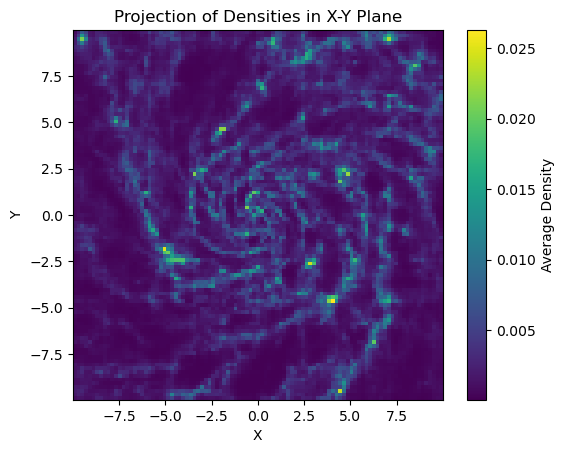

In [363]:
x_min, x_max = -5, 5
grid_size = 100

# Filter particles within the z range
x_coords = grid_coords[:, 0]
x_mask = (x_coords >= x_min) & (x_coords <= x_max)

# Select the particles and densities within this range
filtered_coords = grid_coords[x_mask]
quant = cubes["neut_gas"]

filtered_densities = np.reshape(quant, (512**3))[x_mask].value

# Project onto the x-y plane
y_coords = filtered_coords[:, 1]
z_coords = filtered_coords[:, 2]

# # Create a 2D histogram with the specified grid size
# hist, xedges, yedges = np.histogram2d(y_coords, z_coords, bins=np.linspace(-10,10, 100), weights=filtered_densities, density=False)

# Create a 2D histogram to count the number of points in each bin (density map)
count_hist, xedges, yedges = np.histogram2d(y_coords, z_coords, bins=grid_size)

# Create a 2D histogram weighted by the densities
weighted_hist, _, _ = np.histogram2d(y_coords, z_coords, bins=grid_size, weights=filtered_densities)


# Plot the 2D histogram
plt.figure(dpi=100)
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Average Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Projection of Densities in X-Y Plane')
plt.show()


# Example usage:
# plot_projection(grid_coords, cubes["dark_mat"])


# Convolution of Emissivity

In [30]:
from scipy.fft import fftn, ifftn, fftshift, ifftshift


In [66]:
def create_kernel(shape):
    """
    Create a 3D kernel with a given shape. 
    In this example, we are creating a simple Gaussian kernel.
    
    :param shape: tuple of 3 integers (x, y, z), specifying the shape of the kernel.
    :return: 3D numpy array representing the kernel.
    """
    x, y, z = np.indices(shape)
    center = np.array(shape) // 2
    sigma = min(shape) / 50.0  # Example: a standard deviation for Gaussian kernel
    print('sigma = ',sigma)

    # Gaussian kernel formula
    kernel = np.exp(-((x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2) / (2 * sigma ** 2))
    
    # Normalize the kernel so that the sum is 1
    return kernel

# simple example
# kernel = create_kernel(cubes["aqn_emit"].shape)
# visualize_sum_along_axis(kernel, 2, (0, 512), "Kernel")
# visualize_sum_along_axis_2(kernel*u.K, grid_coords)
# aqn_emit = fft_convolve3d_aligned(cubes["aqn_emit"].value, kernel)
# visualize_sum_along_axis(cubes["aqn_emit"].value, 2, (156, 356), "initial")
# visualize_sum_along_axis(aqn_emit, 2, (156, 356), "convolved")

# visualize_sum_along_axis_2(cubes["aqn_emit"], grid_coords)
# visualize_sum_along_axis_2(aqn_emit*u.K, grid_coords)

# test = fft_convolve3d_aligned(np.ones((512,512,512)), kernel)
# print(test[10][10][0:5], np.sum(kernel))

In [32]:
def fft_convolve3d_aligned(array, kernel):
    """
    Perform a 3D convolution using FFT, ensuring that the (0,0,0) point of the 
    original array and the convolved result align.
    
    :param array: 3D numpy array representing the input data.
    :param kernel: 3D numpy array representing the kernel to convolve with.
    :return: The result of the convolution with aligned origin (0,0,0).
    """
    # Get the shape of the input array and the kernel
    array_shape = array.shape
    kernel_shape = kernel.shape
    
    # Perform FFT on both the input array and the kernel
    fft_array = fftn(array)
    
    # Shift the kernel so that its center aligns with (0,0,0) in frequency space
    fft_kernel = fftn(ifftshift(kernel), s=array_shape) # !!! why

    # Multiply in frequency domain and take inverse FFT to get the result
    convolved = ifftn(fft_array * fft_kernel)
    
    # Return the real part of the result to discard small imaginary parts
    return np.real(convolved)

In [33]:
def visualize_sum_along_axis(array, axis, index_range, title):
    """
    Visualize a sum of pixels along a given axis of a 3D array between two indices.

    :param array: 3D numpy array.
    :param axis: The axis along which to sum (0, 1, or 2).
    :param index_range: Tuple (start_index, end_index) for the range of indices along the given axis.
    :param title: Title of the plot.
    """
    start_idx, end_idx = index_range

    # Sum along the chosen axis in the given index range
    summed_array = np.sum(array.take(indices=range(start_idx, end_idx), axis=axis), axis=axis)

    # Plot the result
    plt.imshow(summed_array, cmap='gray')
    plt.title(f'{title} (Σ index {start_idx}-{end_idx} along axis {axis})')
    plt.colorbar()
    plt.show()

In [34]:
def visualize_sum_along_axis_2(quant, grid_coords):
    z_min, z_max = -2, 2
    grid_size = 100
    
    # Filter particles within the z range
    z_coords = grid_coords[:, 2]
    z_mask = (z_coords >= z_min) & (z_coords <= z_max)
    
    # Select the particles and densities within this range
    filtered_coords = grid_coords[z_mask]
    
    filtered_densities = np.reshape(quant, (512**3))[z_mask].value
    
    # Project onto the x-y plane
    x_coords = filtered_coords[:, 0]
    y_coords = filtered_coords[:, 1]
    
    # Create a 2D histogram to count the number of points in each bin (density map)
    count_hist, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=grid_size)
    
    # Create a 2D histogram weighted by the densities
    weighted_hist, _, _ = np.histogram2d(x_coords, y_coords, bins=grid_size, weights=filtered_densities)
    
    # Normalize by the number of points in each bin to get the average density
    with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
        normalized_hist = np.divide(weighted_hist, count_hist)
        normalized_hist[np.isnan(normalized_hist)] = 0  # Replace NaNs with zeros (where there are no points)
    
    # Plot the normalized 2D histogram
    plt.imshow(normalized_hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # ax.set_colorbar(label='')
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Projection in X-Y Plane, Z ∈ [-2,2] kpc')
    plt.show()

In [68]:
grid_ids, cubes = import_cubes(True)

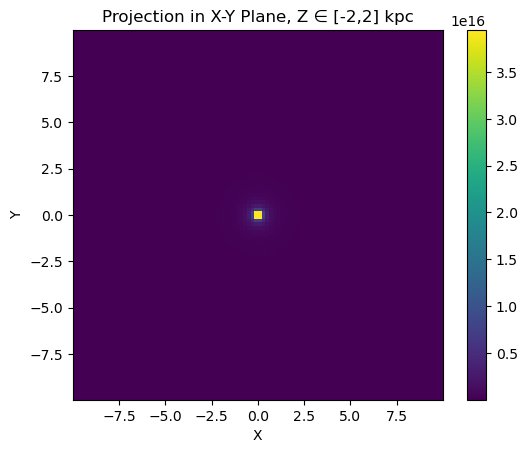

In [73]:
dV = (cube_length / voxel_resolution)**3 # kpc

r                 =                 r.reshape((voxel_resolution, voxel_resolution, voxel_resolution))
z                 =                 z.reshape((voxel_resolution, voxel_resolution, voxel_resolution))
cubes["aqn_emit"] = cubes["aqn_emit"].reshape((voxel_resolution, voxel_resolution, voxel_resolution))
r0 = 0.1

kernel = ((dV/(4*np.pi) * 1/r**2 * np.exp(-np.abs(z)/r0)) * u.kpc).to(u.cm)
visualize_sum_along_axis_2(kernel, grid_coords)

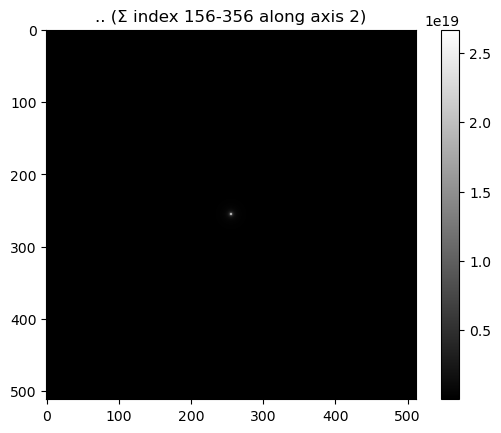

In [83]:
visualize_sum_along_axis(kernel.value,2, (156, 356), "..")

Normalization, 1/K =  6.373476741559699e-22 1 / cm


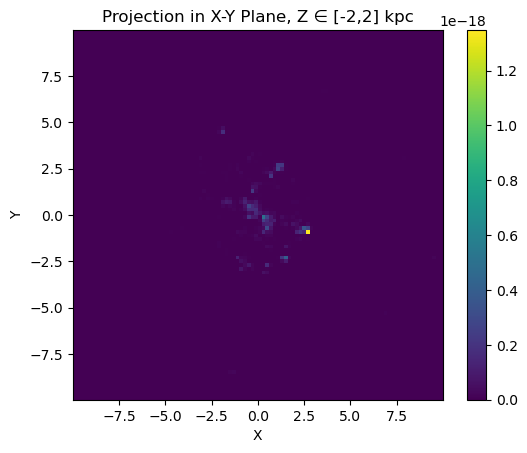

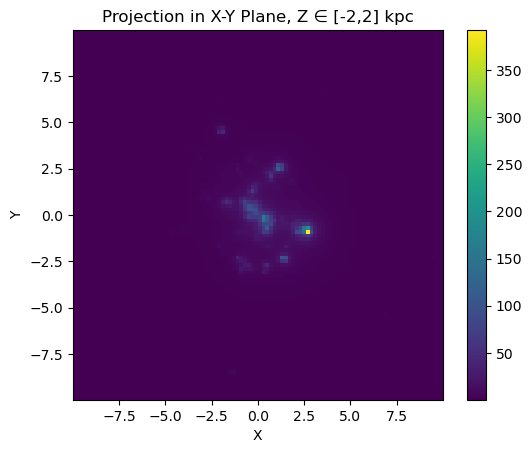

In [74]:
aqn_emit = fft_convolve3d_aligned(cubes["aqn_emit"].value, kernel)
print("Normalization, 1/K = ", 1/np.sum(kernel))
# aqn_emit = aqn_emit / np.sum(kernel)

visualize_sum_along_axis_2(cubes["aqn_emit"], grid_coords)
visualize_sum_along_axis_2(aqn_emit*u.K, grid_coords)

In [34]:
def S(n):
    return 24*(n-1)**2 + 24*(n-1) + 8
print(S(1), S(2), S(3))

8 56 152


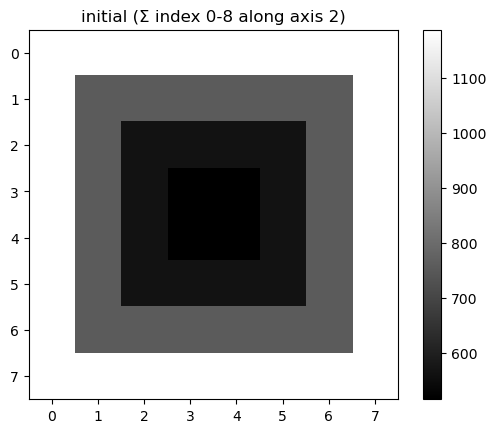

In [107]:
shape = (4,4,4)
corner = np.ones(shape)
corner[0:4, 0:4, 0:4] = S(4)
corner[0:3, 0:3, 0:3] = S(3)
corner[0:2, 0:2, 0:2] = S(2)
corner[0:1, 0:1, 0:1] = S(1)
kernel = np.ones((8,8,8))
kernel[0:4, 0:4, 0:4] = np.rot90(np.rot90(corner))
kernel[4:8, 4:8, 4:8] = corner
kernel[4:8, 0:4, 4:8] = np.rot90(np.rot90(np.rot90(corner)))
kernel[0:4, 4:8, 0:4] = np.rot90(corner)

visualize_sum_along_axis(kernel, 2, (0,8), "initial")

In [55]:
S(1)

8

In [61]:
kernel = np.ones(shape)
for n in [1,2]:
    print(n)
    kernel[0,n,n], kernel[0,n-2:n-1,n], kernel[0,n,n-1] = S(n+1), S(n+1), S(n+1)
kernel

1
2


array([[[  1.,   1., 152.,   1.],
        [ 56.,  56.,   1.,   1.],
        [  1., 152., 152.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]],

       [[  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.]]])

In [49]:
kernel[0,0,0] = 8
kernel[0,1,1] = 56
kernel[0,1,0] = 56
kernel[0,0,1] = 56
kernel

array([[[ 8., 56.,  1.,  1.],
        [56., 56.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]]])

In [45]:
def create_concentric_cubes(size):
    # Ensure the size is even and create an empty 3D array
    assert size % 2 == 0, "Size must be even"
    array = np.zeros((size, size, size), dtype=int)
    
    center = size // 2
    max_n = center  # The maximum shell number
    
    for n in range(1, max_n + 1):
        # Calculate the number of voxels in the current shell
        S_n = 24 * (n-1)**2 + 24 * (n-1) + 8
        
        # Iterate over the cube and fill in the shell
        for x in range(center - n, center + n):
            for y in range(center - n, center + n):
                for z in range(center - n, center + n):
                    if (abs(x - center) == n or
                        abs(y - center) == n or
                        abs(z - center) == n):
                        array[x, y, z] = S_n
    
    return array

# Example usage:
size = 4
concentric_cubes_array = create_concentric_cubes(size)
print(concentric_cubes_array)

[[[56 56 56 56]
  [56 56 56 56]
  [56 56 56 56]
  [56 56 56 56]]

 [[56 56 56 56]
  [56  8  8  0]
  [56  8  8  0]
  [56  0  0  0]]

 [[56 56 56 56]
  [56  8  8  0]
  [56  8  0  0]
  [56  0  0  0]]

 [[56 56 56 56]
  [56  0  0  0]
  [56  0  0  0]
  [56  0  0  0]]]


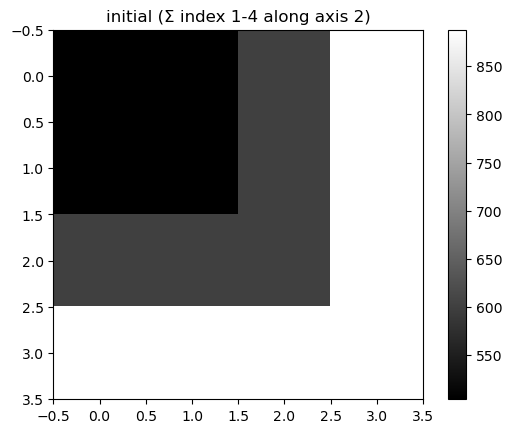

In [80]:
visualize_sum_along_axis(kernel, 2, (1,4), "initial")

# Create histogram of cylinder

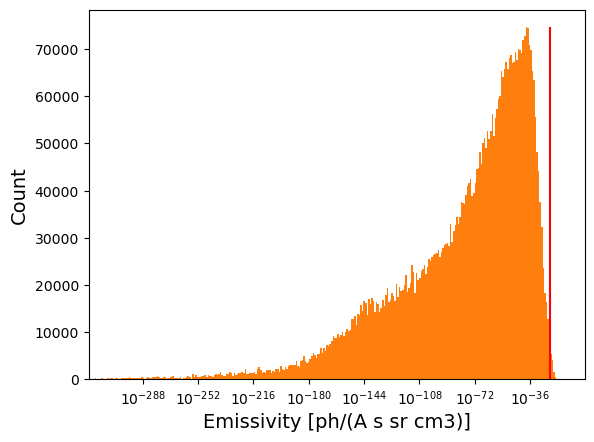

In [29]:
plt.figure(dpi=100)
bins = np.logspace(-324,-16,308)

res = plt.hist(emissivity_cylinder.value, bins=bins)
res = plt.hist(cubes["aqn_emit"].value,   bins=bins)

# plt.xlim([1e-50, 1e-10])
plt.vlines(np.mean(emissivity_cylinder).value, 0,np.max(res[0]), color="red")
# plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")

plt.show()

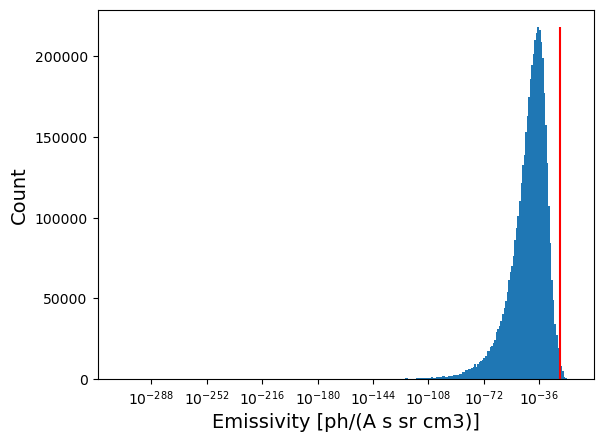

6.424940340623868e-23 ph / (Angstrom s sr cm3)


In [25]:
plt.figure(dpi=100)
bins = np.logspace(-324,-16,308)

res = plt.hist(emissivity_cylinder.value, bins=bins)
# res = plt.hist(cubes["aqn_emit"].value,   bins=bins)

# plt.xlim([1e-50, 1e-10])
plt.vlines(np.mean(emissivity_cylinder).value, 0,np.max(res[0]), color="red")
# plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")

plt.show()
print(np.mean(emissivity_cylinder))

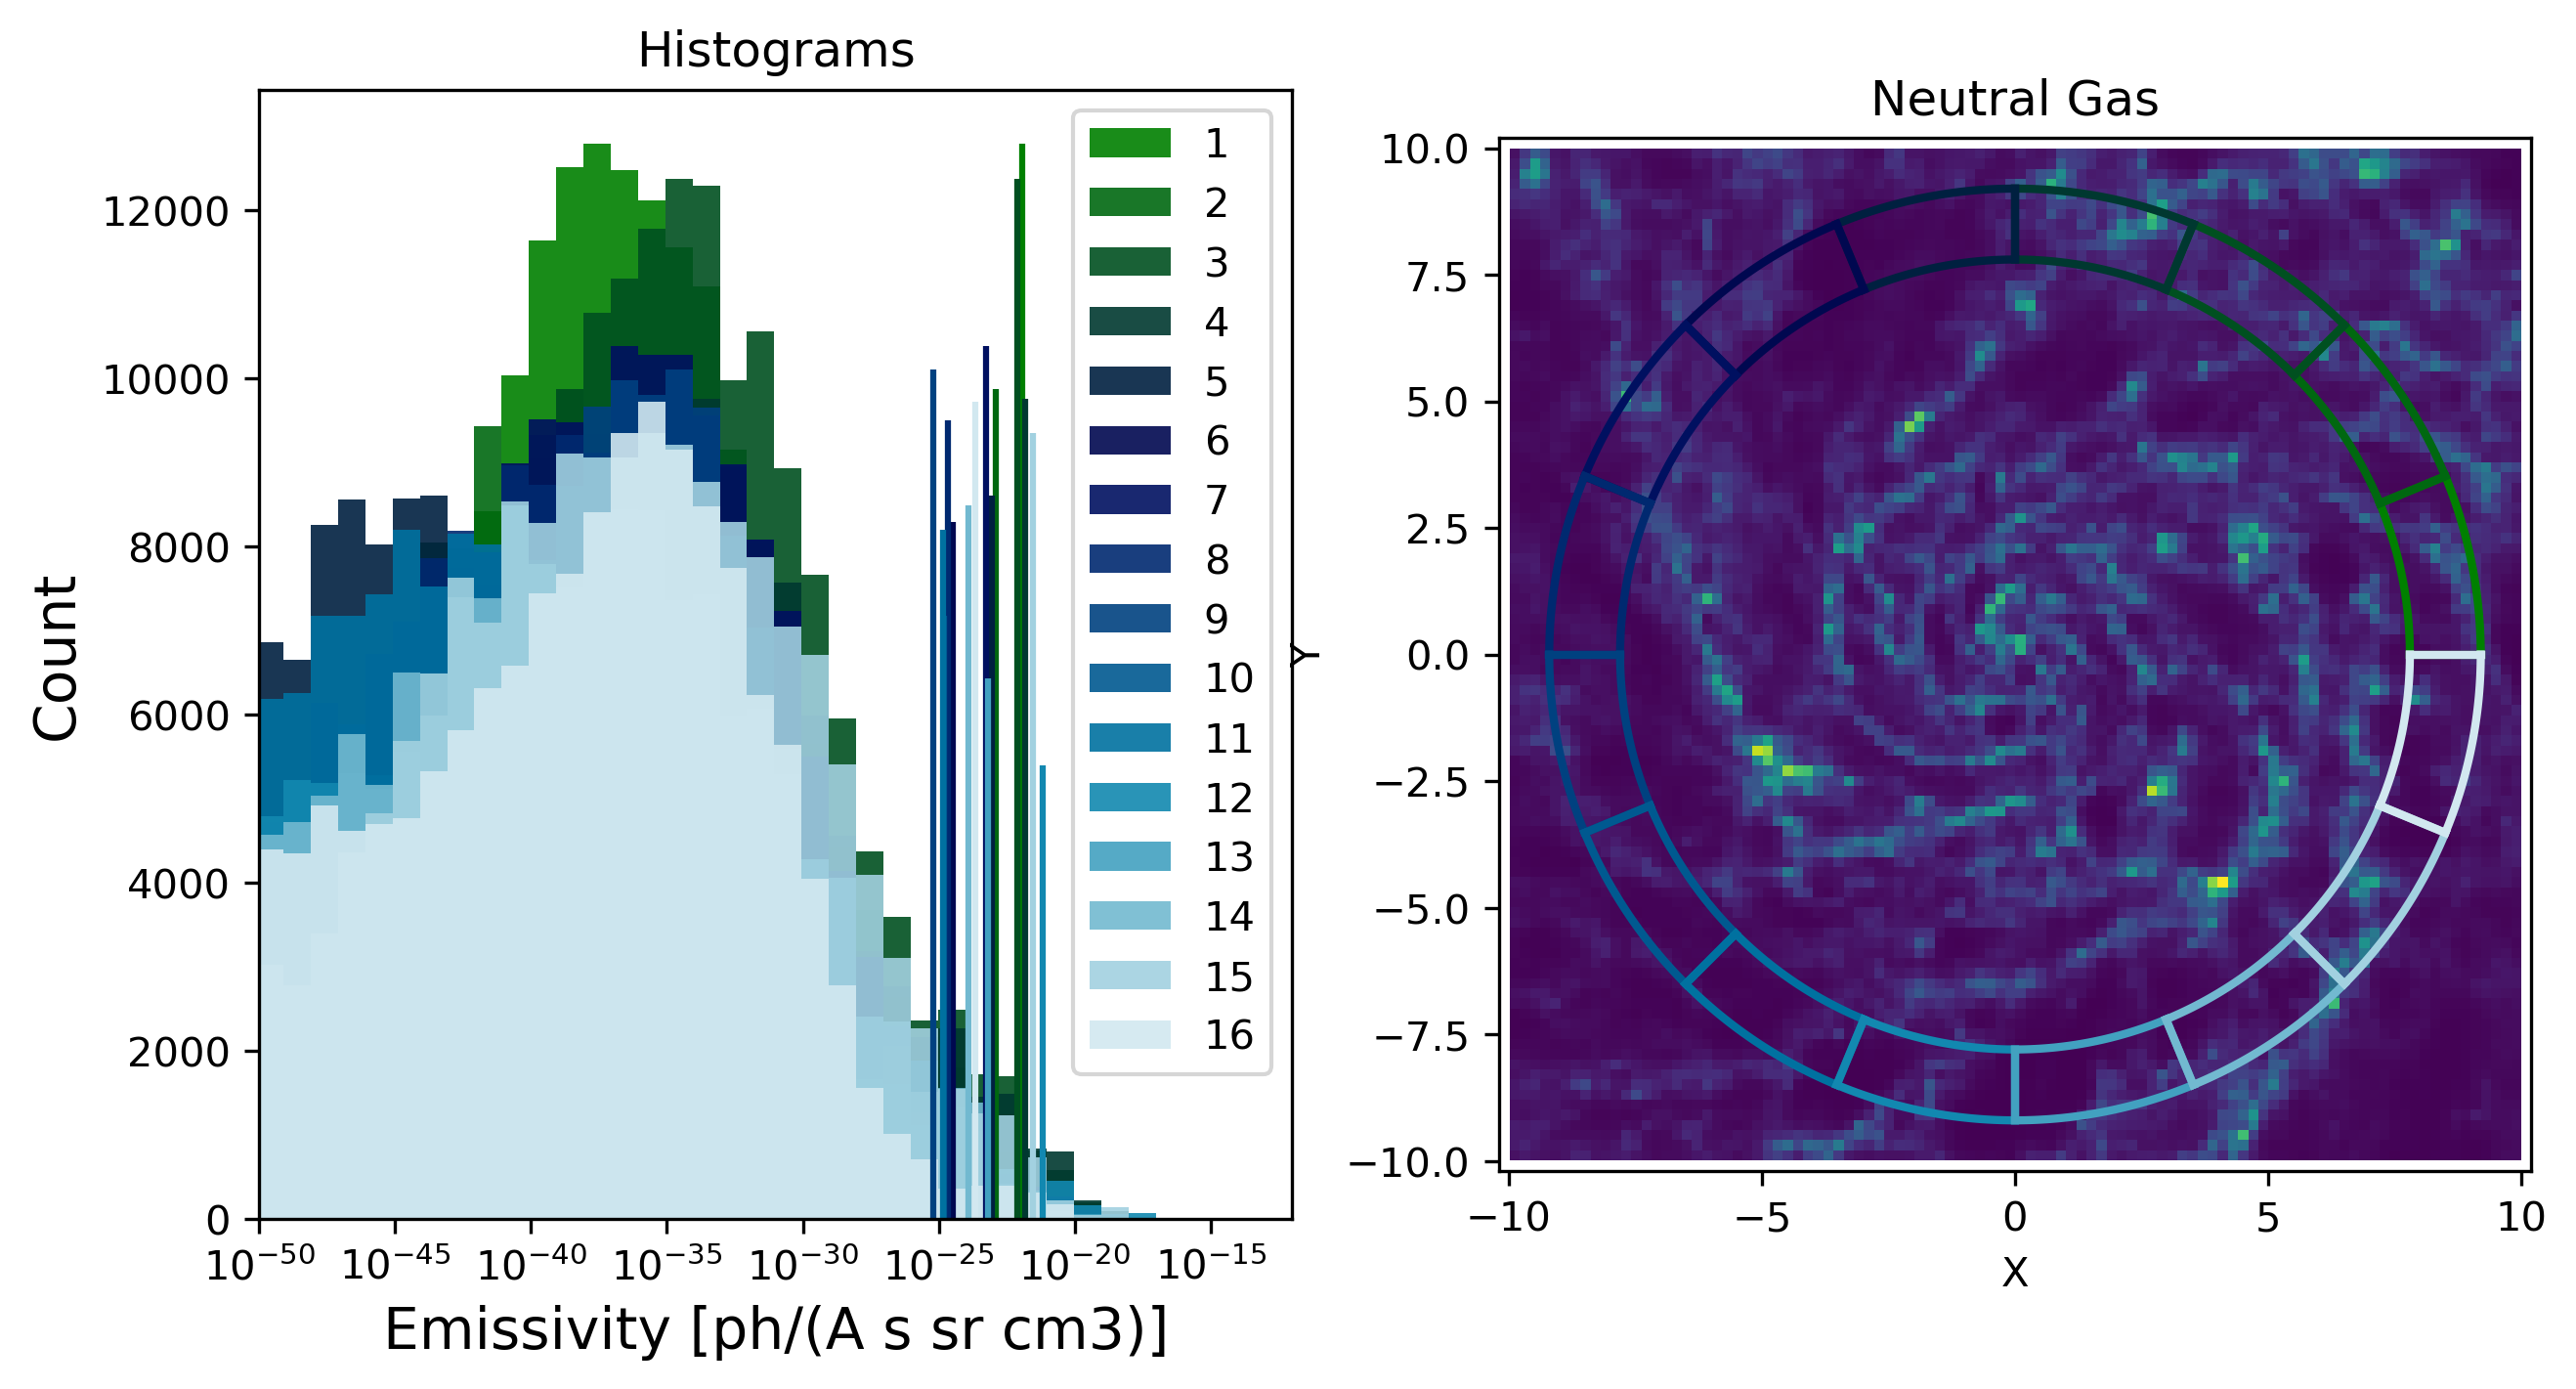

In [24]:
n = 16

filters = generate_cylinder_filters(n)

colors_list = [plt.cm.ocean(i / n) for i in range(16)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax1.set_title("Histograms")
# ax1.axis("off")  # Just a placeholder for now

bins = np.logspace(-324,-16,308)

for i in range(n):
    res = ax1.hist(emissivity_cylinder[filters[i]].value, bins=bins, 
                   color=colors_list[i], alpha = 0.9, label=str(i+1))

# plt.xlim([1e-50, 1e-10])
    ax1.vlines(np.mean(emissivity_cylinder[filters[i]].value), 0,np.max(res[0]), color=colors_list[i])
# plt.yscale("log")
ax1.set_xlim([1e-50, 1e-12])
ax1.set_xscale("log")
ax1.set_ylabel("Count", size=14)
ax1.set_xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
ax1.legend()

# plot_cube(ax2, cubes["neut_gas"], "Neutral Gas", cubes["neut_gas"].unit)
plot_cube_2(ax2, cubes["neut_gas"], grid_coords)
plot_slice_outlines(ax2, "Neutral Gas")


plt.show()

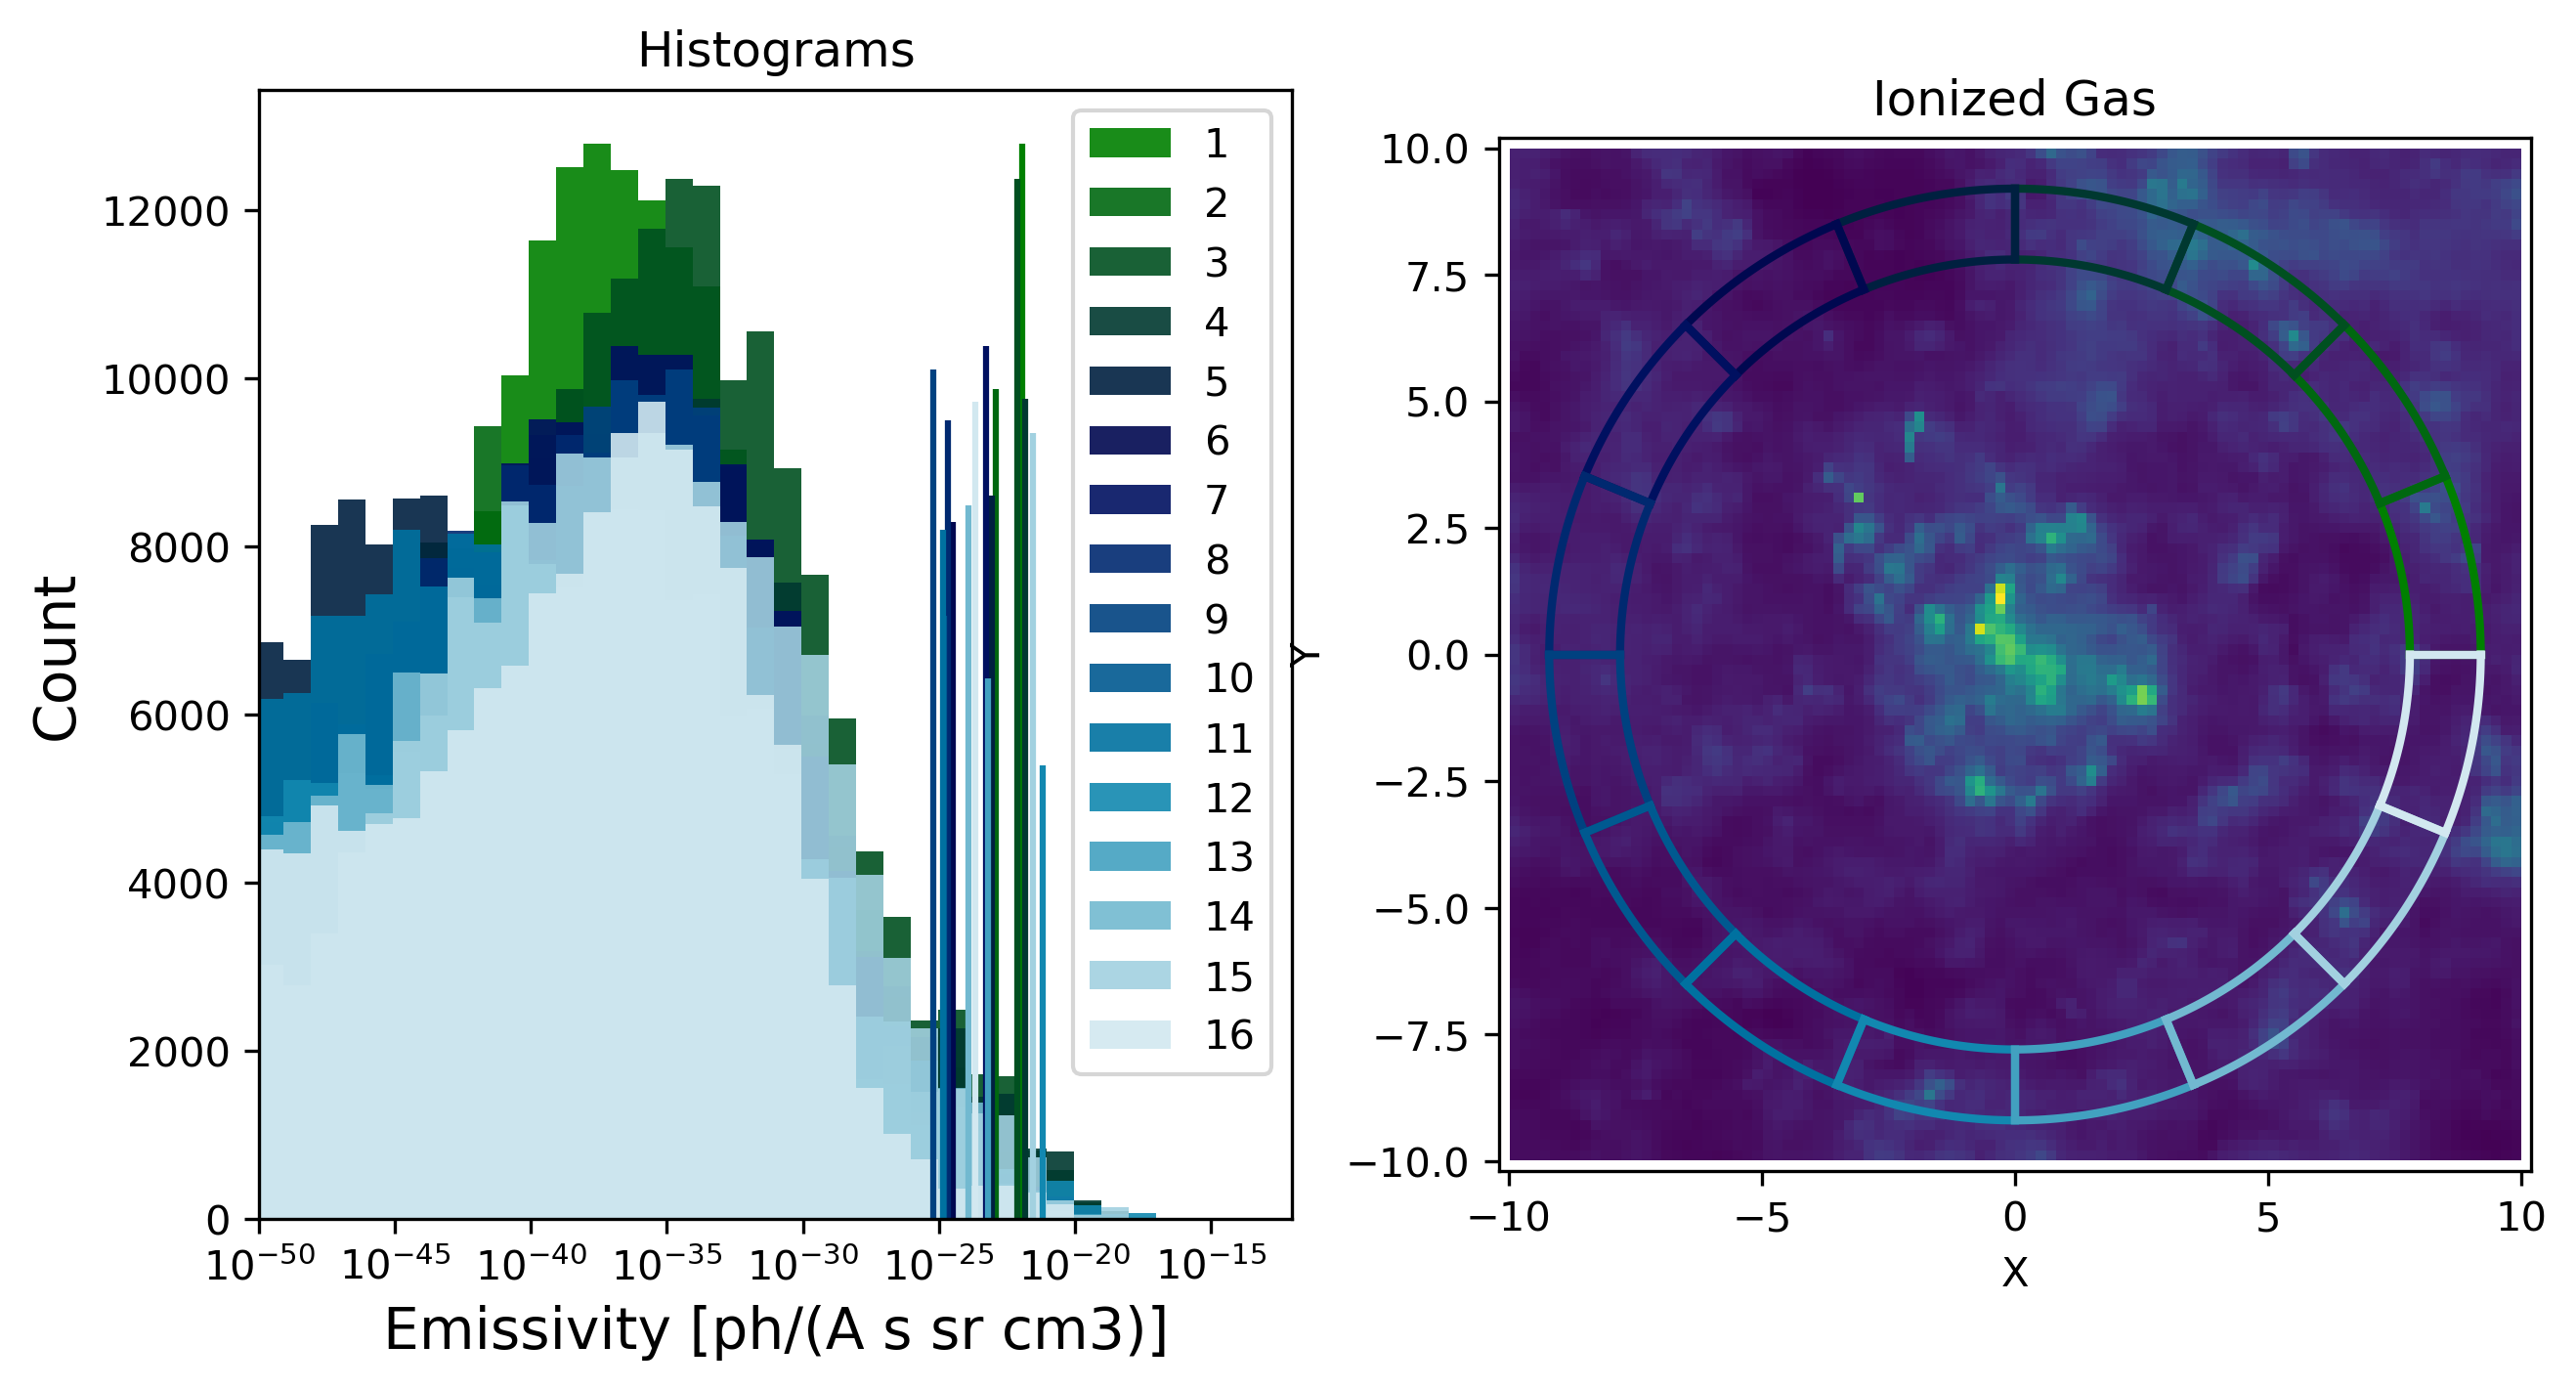

In [30]:
n = 16

filters = generate_cylinder_filters(n)

colors_list = [plt.cm.ocean(i / n) for i in range(16)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax1.set_title("Histograms")
# ax1.axis("off")  # Just a placeholder for now

bins = np.logspace(-324,-16,308)

for i in range(n):
    res = ax1.hist(emissivity_cylinder[filters[i]].value, bins=bins, 
                   color=colors_list[i], alpha = 0.9, label=str(i+1))

# plt.xlim([1e-50, 1e-10])
    ax1.vlines(np.mean(emissivity_cylinder[filters[i]].value), 0,np.max(res[0]), color=colors_list[i])
# plt.yscale("log")
ax1.set_xlim([1e-50, 1e-12])
ax1.set_xscale("log")
ax1.set_ylabel("Count", size=14)
ax1.set_xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
ax1.legend()

# plot_cube(ax2, cubes["neut_gas"], "Neutral Gas", cubes["neut_gas"].unit)
plot_cube_2(ax2, cubes["ioni_gas"], grid_coords)
plot_slice_outlines(ax2, n, "Ionized Gas")


plt.show()

# Histograms for parameter ranges

In [435]:
quants = {}
for cube in cubes:
    quants[cube] = np.reshape(cubes[cube], voxel_resolution**3)[within_cylinder]

aqn_emit = np.reshape(aqn_emit, voxel_resolution**3)[within_cylinder]

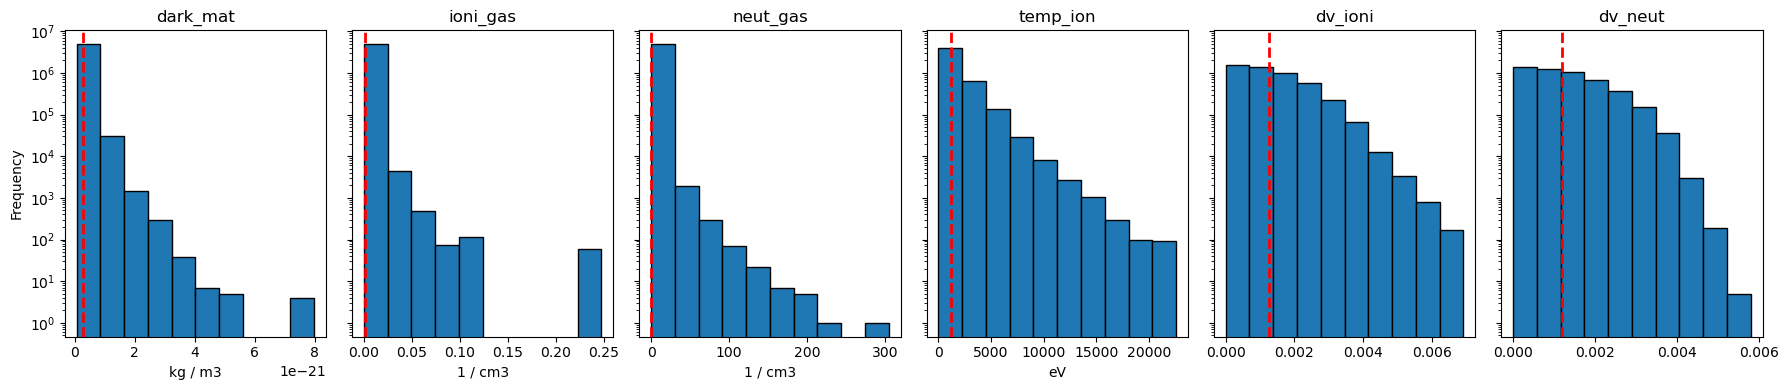

In [65]:
# Create a figure and axes
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharey=True)  # 1 row, 6 columns

# Loop through quants dictionary and create a histogram for each quantity
for ax, (quant_name, quant_data) in zip(axes, quants.items()):
    # Plot the histogram
    ax.hist(quant_data, bins=10, edgecolor='black', log=True)
    
    # Calculate and plot the average as a vertical line
    mean_value = np.mean(quant_data.value)
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    
    # Set title and labels
    ax.set_title(quant_name)
    ax.set_xlabel(quant_data.unit)
    
    # ax.set_xscale("linear")

axes[0].set_ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [51]:
param_ranges = {}
param_ranges["dark_mat"] = [1e-23,1e-21]
param_ranges["ioni_gas"] = [1e-4, 0.3]
param_ranges["neut_gas"] = [1e-4, 300]
# param_ranges["temp_ion"] = 
# param_ranges["dv_ioni"]  = 
# param_ranges["dv_neut"]  = 

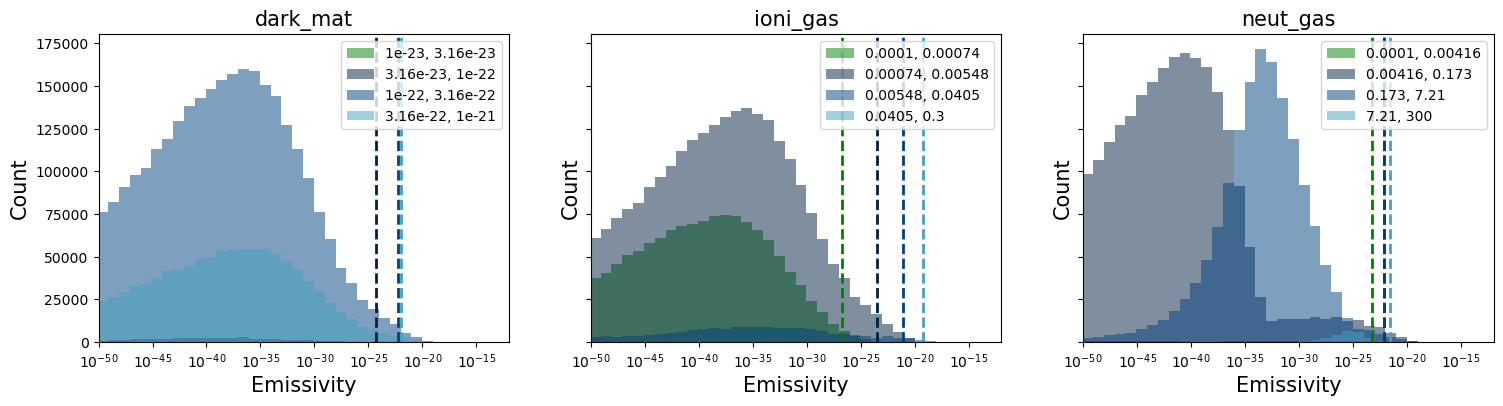

In [103]:
n = 4
filters = generate_cylinder_filters(n)
colors_list = [plt.cm.ocean(i / n) for i in range(n)]

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)  # 1 row, 6 columns
for ax, (quant_name, quant_data) in zip(axes, quants.items()):
    range_values = np.logspace(np.log10(param_ranges[quant_name])[0], 
                               np.log10(param_ranges[quant_name])[1], 
                               num=n+1)
    for i in range(n):
        selected_emissivity = emissivity_cylinder[(quant_data.value > range_values[i]) & \
                                        (quant_data.value < range_values[i+1])].value
        ax.hist(selected_emissivity, 
                bins=bins, log=True, alpha = 0.5, color = colors_list[i],
                label=str("%.3g" % range_values[i])+", "+str("%.3g" % range_values[i+1]))

        if len(selected_emissivity)!=0:
            ax.axvline(np.mean(selected_emissivity), linestyle='dashed', 
                       linewidth=2, color = colors_list[i])

    ax.set_yscale("linear")
    ax.set_xscale("log")
    ax.set_xlim([1e-50, 1e-12])
    ax.set_title(quant_name, size=15)
    ax.set_xlabel("Emissivity", size=15)
    ax.set_ylabel("Count", size=15)
    ax.legend()
    
plt.show()

In [29]:
print(np.min(emissivity_cylinder[emissivity_cylinder!=0]), np.max(emissivity_cylinder))

3.378303796172091e-306 ph / (Angstrom s sr cm3) 1.067296556403684e-17 ph / (Angstrom s sr cm3)


# Looking for solar region candidates

In [258]:
# load all the cubes as mass densities
grid_ids, cubes = import_cubes(True)

In [209]:
grid_ids, cubes = import_cubes(reference=True, location="/arc/projects/unions/lensing/msekatchev/")

FileNotFoundError: [Errno 2] No such file or directory: '/arc/projects/unions/lensing/msekatchev/cubes/cube-aqn_emit.npy'

In [ ]:
lit = {}
lit["dark_mat"] = ((0.4 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["ioni_gas"] = (0.05/u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["neut_gas"] = (0.5 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)

lit["u_dark_mat"] = ((0.04 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["u_ioni_gas"] = (0.02/u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["u_neut_gas"] = (0.2 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)

lit["v_sun"] = (np.sqrt(11.1**2 + 12.24**2 + 7.25**2) + 232.8) * u.km/u.s # +/- 2
lit["z_sun"] = 25 * u.pc # +/- 5
lit["r_sun"] = 8.2 * u.kpc # +/- 0.1

In [225]:
lit = {}
lit["dark_mat"] = ((0.3 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["neut_gas"] = (6.6e-24*u.g/u.cm**3).to(u.kg/u.m**3)  #(0.5 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["ioni_gas"] = 0.1 * lit["neut_gas"] #(0.0005/u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["ioni_gas"] = (0.1 * 1/u.cm**3 * cst.m_p).to(u.kg/u.m**3)

lit["u_dark_mat"] = ((0.1 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["u_neut_gas"] = (0.4  /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["u_ioni_gas"] = (0.4 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["u_ioni_gas"] = (0.09/u.cm**3          *cst.m_p).to(u.kg/u.m**3)

lit["v_sun"] = (np.sqrt(11.1**2 + 12.24**2 + 7.25**2) + 232.8) * u.km/u.s # +/- 2
lit["z_sun"] = 25 * u.pc # +/- 5
lit["r_sun"] = 8.2 * u.kpc # +/- 0.1

In [226]:
for i in lit.keys():
    print(i, (lit[i] / cst.m_p).cgs)

dark_mat 0.31973667743666834 1 / cm3
neut_gas 3.945900688327477 1 / cm3
ioni_gas 0.1 1 / cm3
u_dark_mat 0.10657889247888944 1 / cm3
u_neut_gas 0.4 1 / cm3
u_ioni_gas 0.09 1 / cm3
v_sun 1.499706011450902e+31 cm / (g s)
z_sun 4.612036853319489e+43 cm / g
r_sun 1.5127480878887923e+46 cm / g


In [175]:
lit["ioni_gas"]

<Quantity 1.32e-21 kg / m3>

In [176]:
cubes["ioni_gas_ref"]

<Quantity [2.06085016e-24, 2.06085016e-24, 2.06085016e-24, ...,
           5.97703351e-25, 5.97703351e-25, 5.97703351e-25] kg / m3>

In [259]:
# reshape cubes to only within the cylinder
for quant in cubes:
    cubes[quant] = np.reshape(cubes[quant], voxel_resolution**3)#[within_cylinder]

aqn_emit = np.reshape(aqn_emit, voxel_resolution**3)

density_filter = np.where(
                          # (cubes["dark_mat_ref"] < (lit["dark_mat"] + lit["u_dark_mat"])) & \
                          # (cubes["dark_mat_ref"] > (lit["dark_mat"] - lit["u_dark_mat"])) & \
                          (cubes["ioni_gas_ref"] < (lit["ioni_gas"] + lit["u_ioni_gas"])) & \
                          (cubes["ioni_gas_ref"] > (lit["ioni_gas"] - lit["u_ioni_gas"])) & \
                          # (cubes["neut_gas_ref"] < (lit["neut_gas"] + lit["u_neut_gas"])) & \
                          # (cubes["neut_gas_ref"] > (lit["neut_gas"] - lit["u_neut_gas"])) & \
                          (s < 9.2) & (s > 7.8) # & \
                          # (np.abs(z) < 0.1)
                )

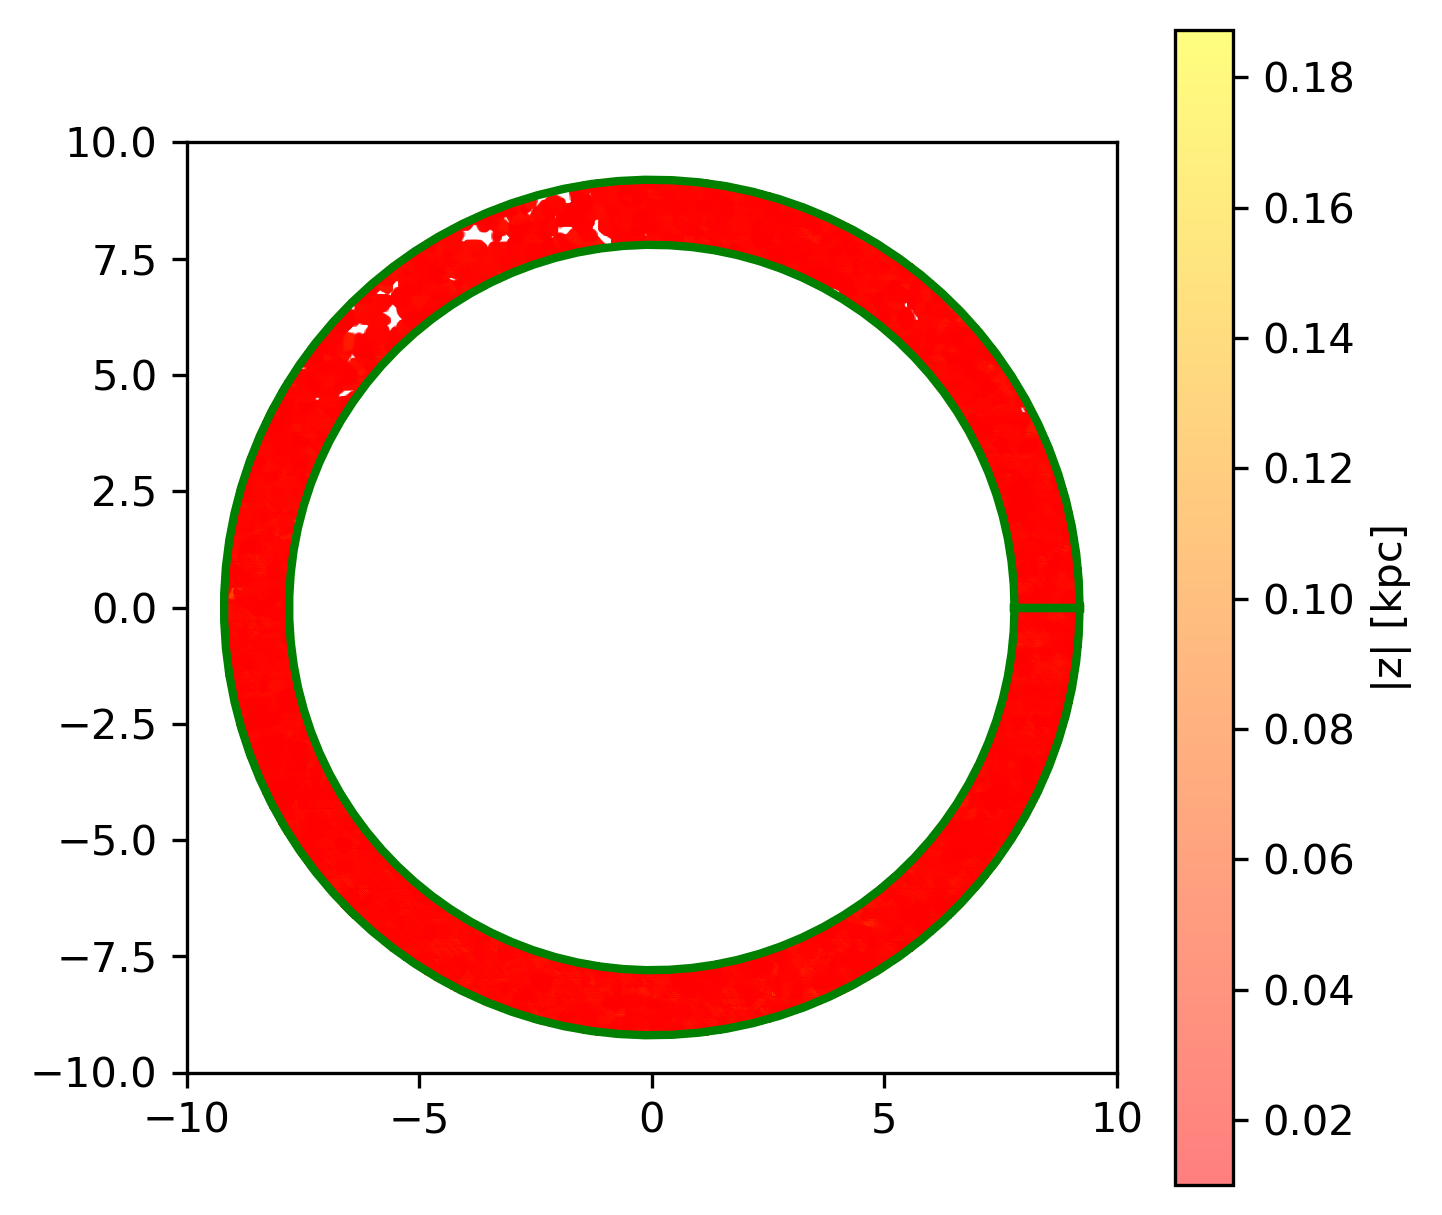

In [260]:
# fig, axs = plt.subplots(1, figsize=(5,5), dpi=300)
# scat = axs.scatter(x[density_filter], y[density_filter], 
#                    s=0.5, alpha=0.5, 
#                    c=np.abs(z[density_filter]), cmap='autumn')
# plt.colorbar(scat, label='|z| [kpc]')
# plot_slice_outlines(axs, 1, " ")
# axs.set_xlim([-10,10])
# axs.set_ylim([-10,10])
# plt.show()

fig, axs = plt.subplots(1, figsize=(5,5), dpi=300)
scat = axs.scatter(x[density_filter], y[density_filter], 
                   s=0.5, alpha=0.5, 
                   c=cubes["ioni_gas"][density_filter].value, cmap='autumn')
plt.colorbar(scat, label='|z| [kpc]')
plot_slice_outlines(axs, 1, " ")
axs.set_xlim([-10,10])
axs.set_ylim([-10,10])
plt.show()

In [246]:
R_aqn_cm = calc_R_AQN(m_aqn_kg)

# cubes["dark_mat"] = (cubes["dark_mat"] / m_aqn_kg).to(1/u.cm**3)

# compute T_AQN
cubes["t_aqn_n"] = T_AQN_analytical(cubes["neut_gas"][density_filter], cubes["dv_neut"][density_filter], f, g)
cubes["t_aqn_i"] = T_AQN_ionized2(  cubes["ioni_gas"][density_filter], cubes["dv_ioni"][density_filter], f, g, 
                                    cubes["temp_ion"][density_filter], R_aqn_cm)
# if ioni temp is lower than neut temp, replace with neut temp
cubes["t_aqn_i"][cubes["t_aqn_i"]<cubes["t_aqn_n"]] = \
cubes["t_aqn_n"][cubes["t_aqn_i"]<cubes["t_aqn_n"]]



In [271]:
np.max(aqn_emit[density_filter])

250.2135455240557

(array([1.811393e+06, 1.492000e+03, 2.260000e+02, 8.700000e+01,
        4.000000e+01, 1.800000e+01, 1.200000e+01, 1.000000e+01,
        8.000000e+00, 5.000000e+00, 0.000000e+00, 6.000000e+00,
        1.000000e+00, 3.000000e+00, 2.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 3.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00, 2.000000e+00, 1.000000e+00,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 2.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 3.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([3.18149686e-06, 5.00427403e+00, 1.00085449e+01, 1.50128157e+01,
        2.00170866e+01, 2.50213574e+01, 3.00256283e+01, 3.50298991e+01,
        4.00341700e+01, 4.50384408e+01, 5.00427117

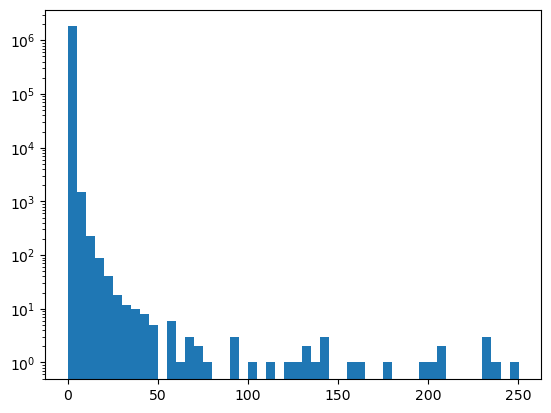

In [272]:
plt.hist(aqn_emit[density_filter], bins=50, log=True)

(array([1.813253e+06, 2.600000e+01, 2.300000e+01, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.700000e+01]),
 array([0.00000000e+00, 1.46655826e-19, 2.93311652e-19, 4.39967478e-19,
        5.86623304e-19, 7.33279130e-19, 8.79934956e-19, 1.02659078e-18,
        1.17324661e-18, 1.31990243e-18, 1.46655826e-18]),
 <BarContainer object of 10 artists>)

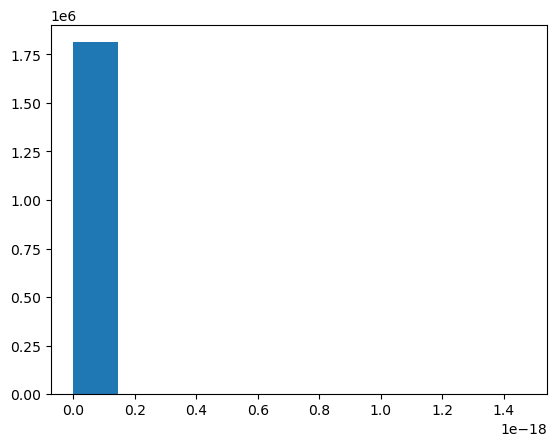

In [261]:
plt.hist(cubes["aqn_emit"][density_filter])

(array([4., 0., 2., 0., 0., 1., 4., 3., 0., 1.]),
 array([0.24234644, 0.26655959, 0.29077274, 0.31498589, 0.33919904,
        0.36341219, 0.38762534, 0.4118385 , 0.43605165, 0.4602648 ,
        0.48447795]),
 <BarContainer object of 10 artists>)

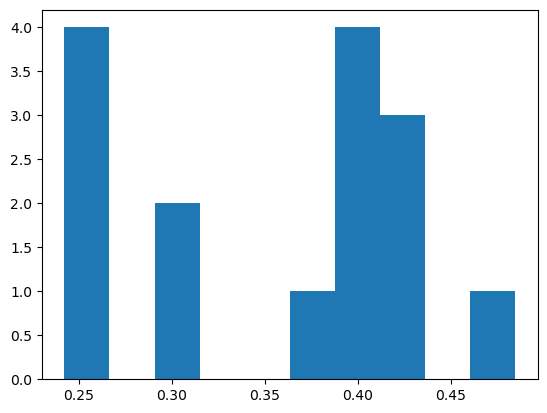

In [248]:
plt.hist(cubes["t_aqn_n"])

(array([10.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.]),
 array([0.37481098, 0.69013841, 1.00546584, 1.32079327, 1.6361207 ,
        1.95144813, 2.26677557, 2.582103  , 2.89743043, 3.21275786,
        3.52808529]),
 <BarContainer object of 10 artists>)

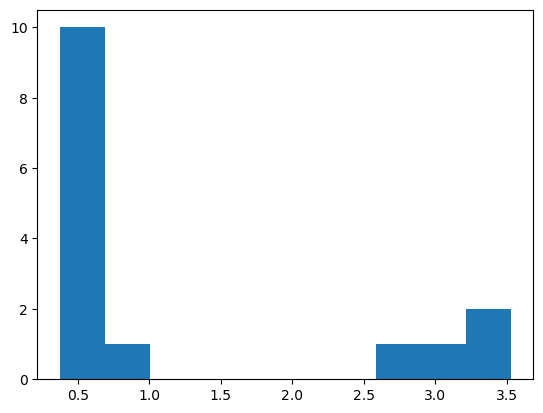

In [249]:
plt.hist(cubes["t_aqn_i"])

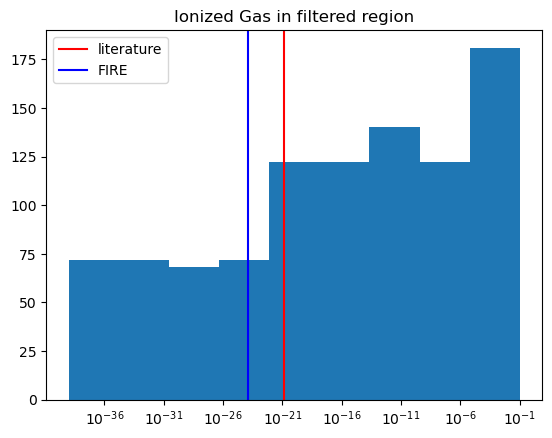

In [198]:
ioni_gas_filtered_densities = (cubes["ioni_gas_ref"][density_filter]/cst.m_p).to(1/u.cm**3)
plt.hist(ioni_gas_filtered_densities.value, bins=np.logspace(-39, -1,10))
plt.axvline(lit["ioni_gas"].value, c="red", label="literature")
plt.axvline(np.mean(cubes["ioni_gas_ref"][density_filter].value), c="blue", label="FIRE")
plt.xscale("log")
plt.yscale("linear")
plt.title("Ionized Gas in filtered region")
plt.legend()
plt.show()

In [211]:
np.max(((cubes["ioni_gas"+"_ref"][density_filter])/cst.m_p).to(1/u.cm**3))

IndexError: index 6414079 is out of bounds for axis 0 with size 512

In [180]:
cubes["ioni_gas_ref"]

<Quantity [2.06085016e-24, 2.06085016e-24, 2.06085016e-24, ...,
           5.97703351e-25, 5.97703351e-25, 5.97703351e-25] kg / m3>

In [181]:
lit["ioni_gas"]

<Quantity 1.32e-21 kg / m3>

0.13619168257807857 1 / cm3 0.31973667743666834 1 / cm3
0.0164747411842701 1 / cm3 0.1 1 / cm3
0.02388881959838803 1 / cm3 3.945900688327477 1 / cm3


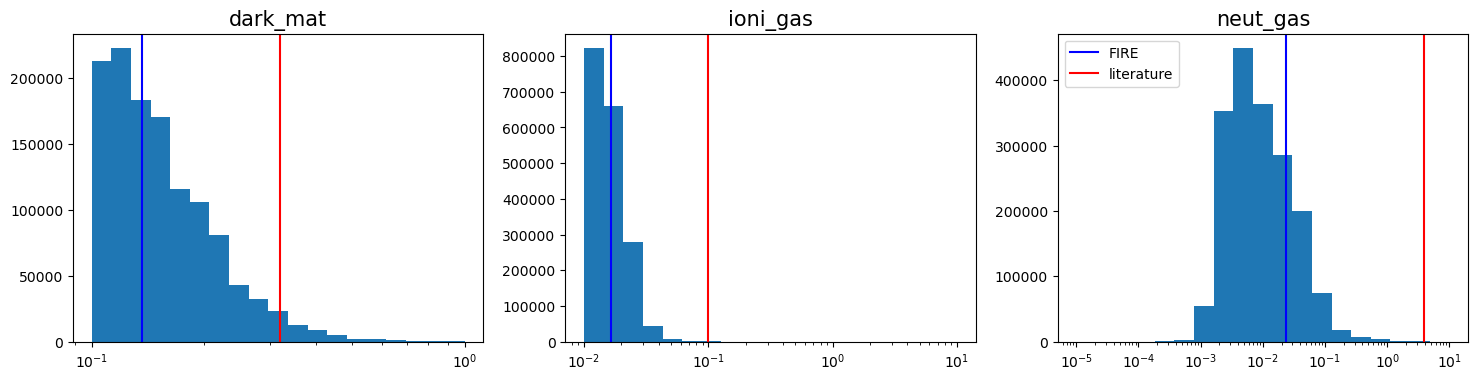

In [263]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)  # 1 row, 6 columns
for ax, quant, limits in zip(axes, ["dark_mat", "ioni_gas", "neut_gas"], [[-1,0],[-2,1],[-5,1]]):
    bins=np.logspace(limits[0], limits[1],20)

    ax.hist(((cubes[quant+"_ref"][density_filter]/cst.m_p).to(1/u.cm**3)).value, bins=bins)
    ax.axvline(((np.mean(cubes[quant+"_ref"][density_filter]/cst.m_p).to(1/u.cm**3)).value), c="blue", label="FIRE")
    ax.axvline(((lit[quant]/cst.m_p).to(1/u.cm**3)).value, c="red", label="literature")

    # for i in range(n):
    #     selected_emissivity = emissivity_cylinder[(quant_data.value > range_values[i]) & \
    #                                     (quant_data.value < range_values[i+1])].value
    #     ax.hist(selected_emissivity, 
    #             bins=bins, log=True, alpha = 0.5, color = colors_list[i],
    #             label=str("%.3g" % range_values[i])+", "+str("%.3g" % range_values[i+1]))

    #     if len(selected_emissivity)!=0:
    #         ax.axvline(np.mean(selected_emissivity), linestyle='dashed', 
    #                    linewidth=2, color = colors_list[i])
    print((np.mean(cubes[quant+"_ref"][density_filter]/cst.m_p).to(1/u.cm**3)), (lit[quant]/cst.m_p).to(1/u.cm**3))
    ax.set_yscale("linear")
    ax.set_xscale("log")
    # ax.set_xlim([1e-50, 1e-12])
    ax.set_title(quant, size=15)
    # ax.set_xlabel("Emissivity", size=15)
    # ax.set_ylabel("Count", size=15)
plt.legend()
    
plt.show()

In [233]:
(np.max(cubes["ioni_gas_ref"][density_filter]) / cst.m_p).to(1/u.cm**3)

<Quantity 0.10927409 1 / cm3>

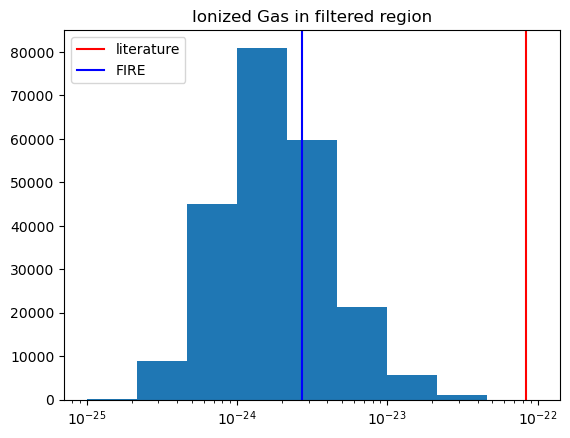

In [155]:
plt.hist(cubes["ioni_gas_ref"][density_filter].value, bins=np.logspace(-25, -22,10))
plt.axvline(lit["ioni_gas"].value, c="red", label="literature")
plt.axvline(np.mean(cubes["ioni_gas_ref"][density_filter].value), c="blue", label="FIRE")
plt.xscale("log")
plt.yscale("linear")
plt.title("Ionized Gas in filtered region")
plt.legend()
plt.show()

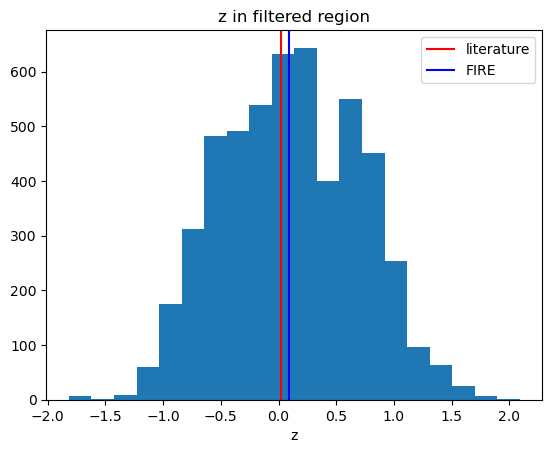

0.09098448006724304


In [343]:
plt.hist(z[density_filter], bins=20)
plt.axvline(z_sun.to(u.kpc).value, c="red", label="literature")
plt.axvline(np.mean(z[density_filter]), c="blue", label="FIRE")
plt.title("z in filtered region")
plt.xlabel("z")
plt.legend()
plt.show()
print(np.mean(z[density_filter]))

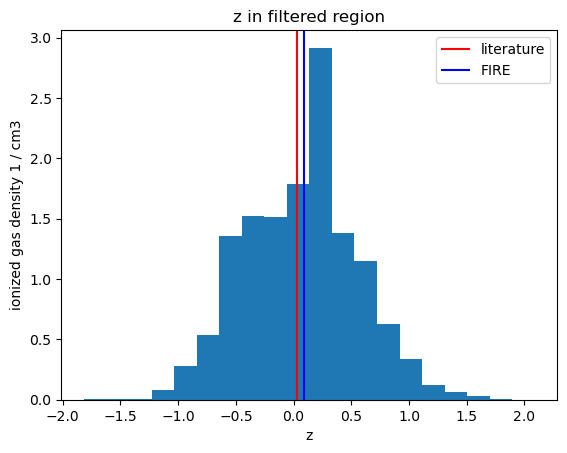

0.09098448006724304


In [349]:
plt.hist(z[density_filter], weights = cubes["ioni_gas"][density_filter].value, bins=20)
plt.axvline(z_sun.to(u.kpc).value, c="red", label="literature")
plt.axvline(np.mean(z[density_filter]), c="blue", label="FIRE")
plt.title("z in filtered region")
plt.xlabel("z")
plt.ylabel("ionized gas density " + str(cubes["ioni_gas"].unit))
plt.legend()
plt.show()
print(np.mean(z[density_filter]))

0.10802396971861292

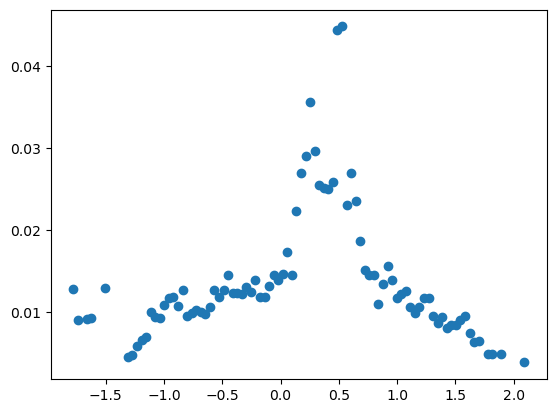

In [140]:
res = stats.binned_statistic(z[density_filter],
                          aqn_emit[density_filter],
                          statistic='mean',
                          bins=100)
plt.plot(res[1][1:len(res[1])], res[0], "o")
np.max(cubes["ioni_gas"][density_filter].value)

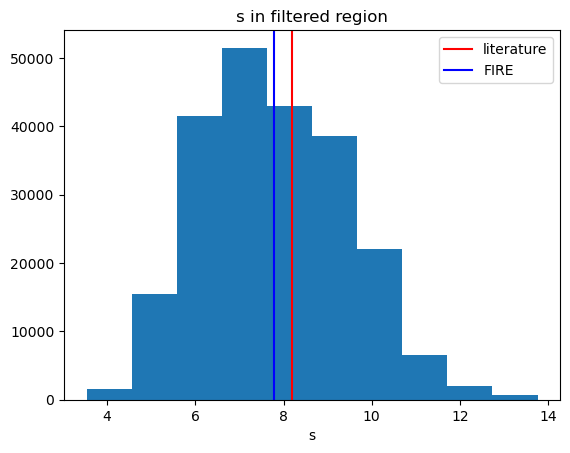

7.790277517271067


In [153]:
plt.hist(s[density_filter], bins=10)
plt.axvline(r_sun.to(u.kpc).value, c="red", label="literature")
plt.axvline(np.mean(s[density_filter]), c="blue", label="FIRE")
plt.title("s in filtered region")
plt.xlabel("s")
plt.legend()
plt.show()
print(np.mean(s[density_filter]))

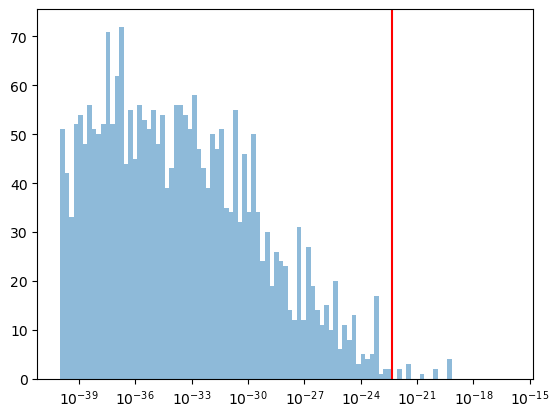

In [76]:
# region_filter = np.where(cubes[i] < lit[i]+lit["u_"+i] for i in ["dark_mat", "ioni_gas", "neut_gas"])
bins = np.logspace(-40,-16,100)

plt.hist(cubes["aqn_emit"][density_filter].value, 
                bins=bins, log=True, alpha = 0.5)
plt.axvline(np.mean(cubes["aqn_emit"][density_filter].value), color="red")
plt.xscale("log")
plt.yscale("linear")
# cubes["aqn_emit"][np.where(cubes["dark_mat"] < lit["dark_mat"] + lit["u_dark_mat"])]

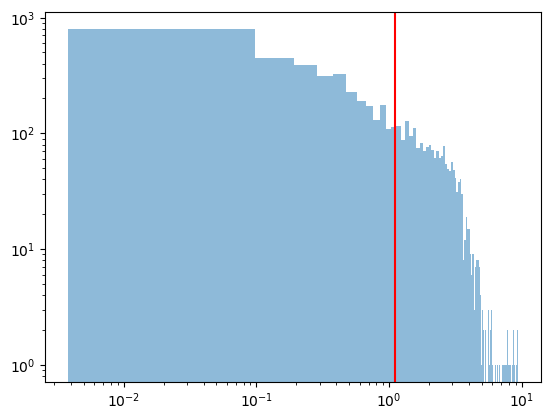

In [77]:
# region_filter = np.where(cubes[i] < lit[i]+lit["u_"+i] for i in ["dark_mat", "ioni_gas", "neut_gas"])
# bins = np.logspace(-40,-16,100)
aqn_emit = np.reshape(aqn_emit, 512**3)
plt.hist(aqn_emit[density_filter], 
                bins=100, log=True, alpha = 0.5)
plt.axvline(np.mean(aqn_emit[density_filter]), color="red")
plt.xscale("log")
plt.yscale("log")
# plt.yscale("linear")
# cubes["aqn_emit"][np.where(cubes["dark_mat"] < lit["dark_mat"] + lit["u_dark_mat"])]

In [78]:
np.max(aqn_emit[density_filter])

9.431802665492174

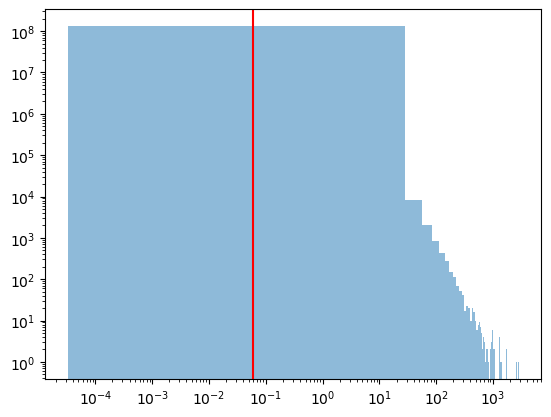

In [142]:
# region_filter = np.where(cubes[i] < lit[i]+lit["u_"+i] for i in ["dark_mat", "ioni_gas", "neut_gas"])
# bins = np.logspace(-40,-16,100)

plt.hist(aqn_emit, 
                bins=100, log=True, alpha = 0.5)
plt.axvline(np.mean(aqn_emit), color="red")
plt.xscale("log")
plt.yscale("log")
# plt.yscale("linear")
# cubes["aqn_emit"][np.where(cubes["dark_mat"] < lit["dark_mat"] + lit["u_dark_mat"])]

In [125]:
np.mean(aqn_emit)

1.796125480516561

In [122]:
np.mean(aqn_emit[density_filter])

0.771648961436015

In [368]:
cubes["aqn_emit"].unit


Unit("ph / (Angstrom s sr cm3)")

In [305]:
np.mean(cubes["aqn_emit"][density_filter].value)

2.9180258985644622e-24

# Skewed Distribution Example

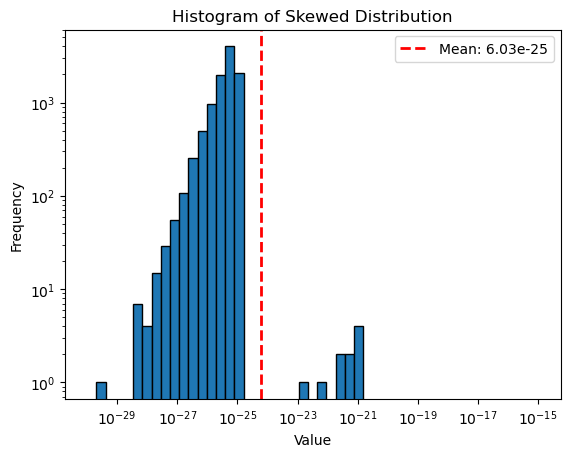

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a large number of small values and a few large values
small_values = np.random.uniform(1e-30, 1e-25, 10000)
large_values = np.random.uniform(1e-23, 1e-21, 10)

# Combine the values
data = np.concatenate((small_values, large_values))
# data = small_values
# Calculate mean
mean_value = np.mean(data)
bins = np.logspace(-30,-15,50)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black', log=True)
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2e}')
plt.title('Histogram of Skewed Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xscale('log')
plt.legend()
plt.show()


In [200]:
import scipy
scipy.stats.mode(emissivity_cylinder)

ModeResult(mode=0.0, count=7115)

2.5873529001186704 eV 13439.365093048658 eV


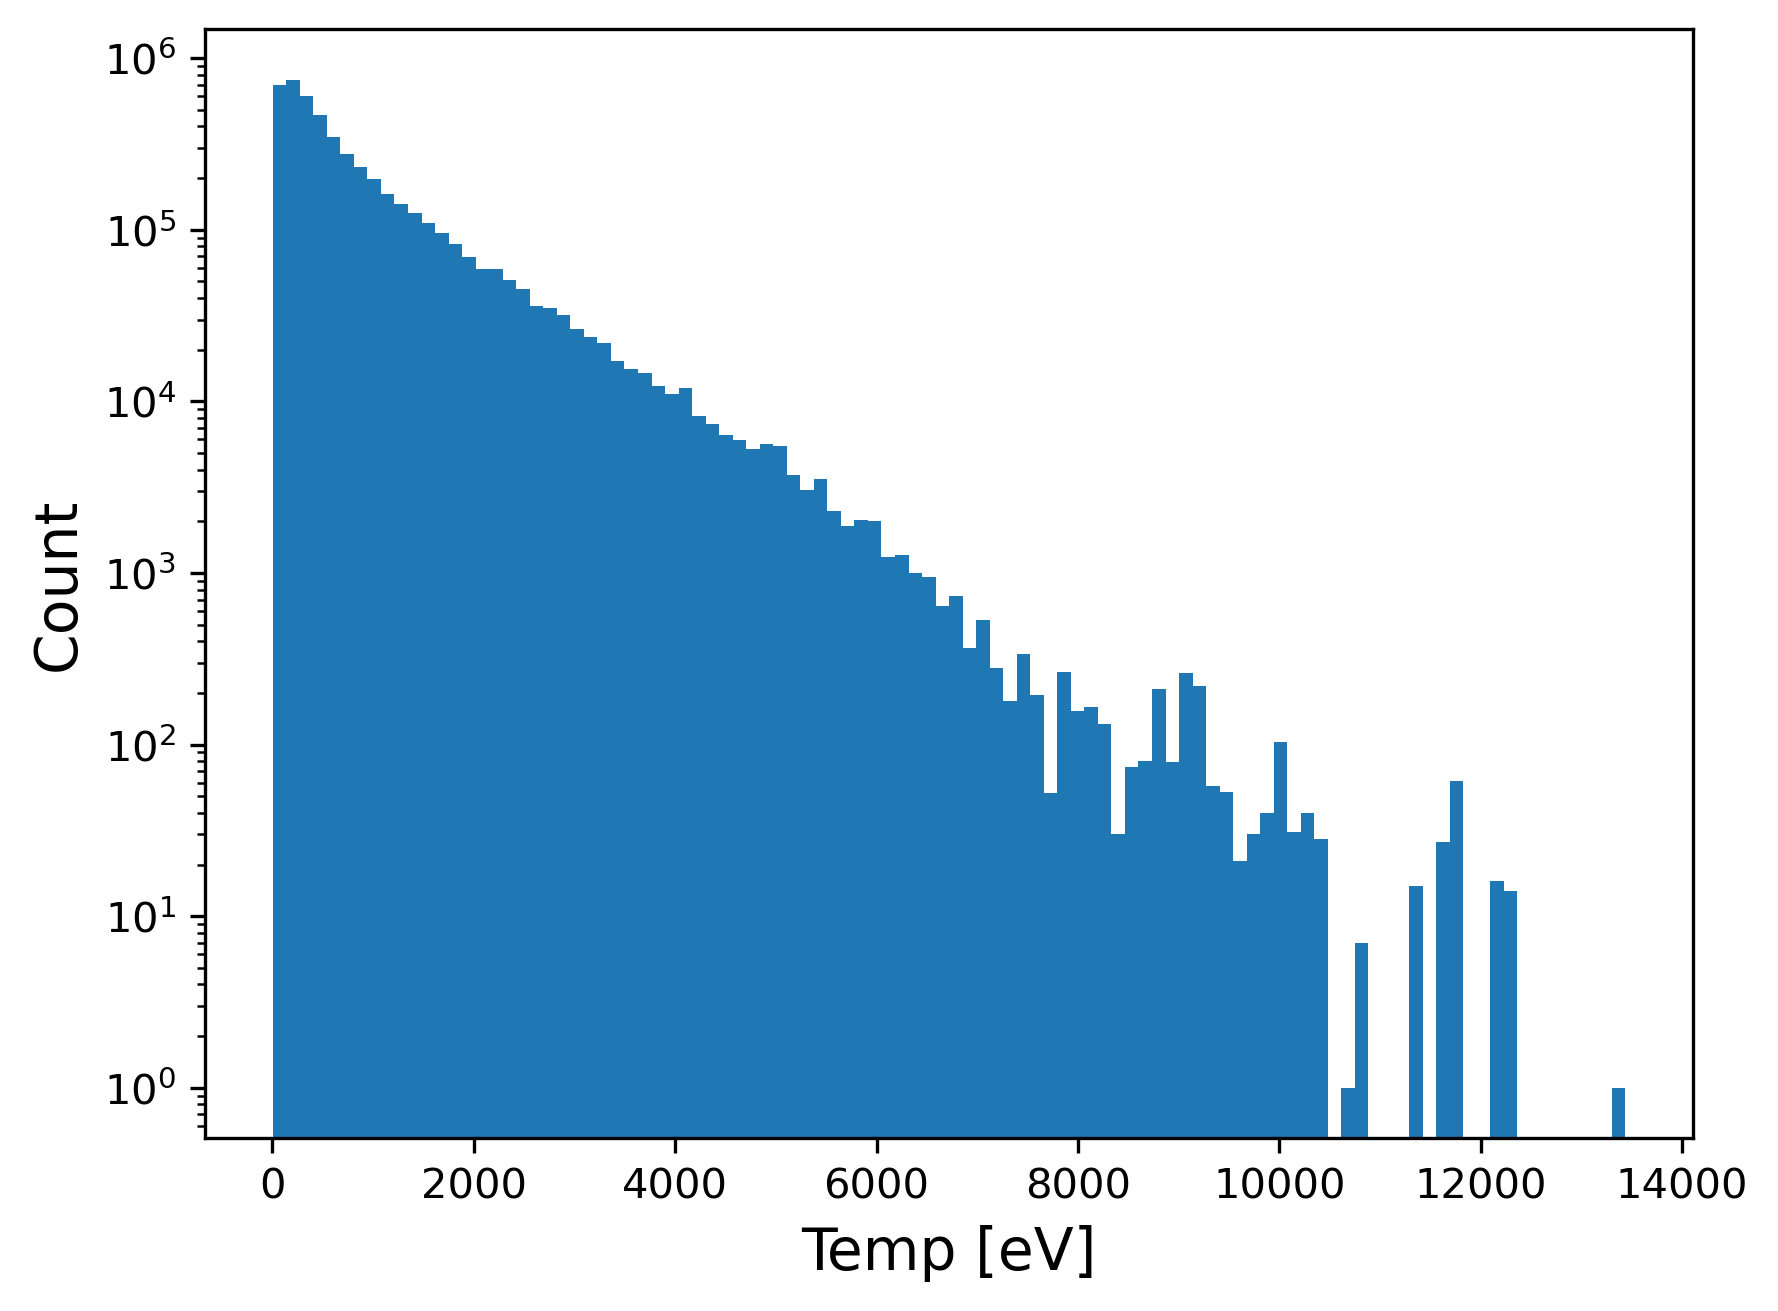

In [175]:
print(np.min(emissivity_cylinder[emissivity_cylinder!=0]), np.max(emissivity_cylinder))
plt.figure(dpi=300)
# bins = np.logspace(-324,-10,314)
res = plt.hist(emissivity_cylinder.value, bins=100)
# plt.xlim([1e-28, 1e-10])
# plt.xlim([])
plt.yscale("log")
# plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.xlabel("Temp [eV]", size=14)
plt.savefig("../visuals/emissivity_histogram.png")
plt.show()

In [172]:
cube_dv

array([[[149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        ...,
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         102077.75151772, 103512.07037661, 103512.07037661],
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         123897.41474999, 123897.41474999, 122463.09589109],
        [ 84527.96509   ,  84527.96509   ,  84527.96509   , ...,
         123897.41474999, 123897.41474999, 123897.41474999]],

       [[149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732956, 247641.26732956],
        [149367.71991048, 149367.71991048, 149367.71991048, ...,
         247641.26732956, 247641.26732

In [173]:
cube_eff = cube * K_to_eV + 1/2 * (938 * u.MeV).to(u.eV) * (cube_dv/cst.c.value)**2

<Quantity 9.72359414 ph / (Angstrom s sr cm2)>

# Define simulation resolution

In [110]:
NSIDE = 2**5
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)

# Sample from histogram to generate skymap

In [125]:
hist = res[0]

bin_midpoints = (bins[:-1] + bins[1:])/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

values = np.random.rand(NPIX)
value_bins = np.searchsorted(cdf, values)
sampled_emissivity = bin_midpoints[value_bins] * emissivity_cylinder.unit

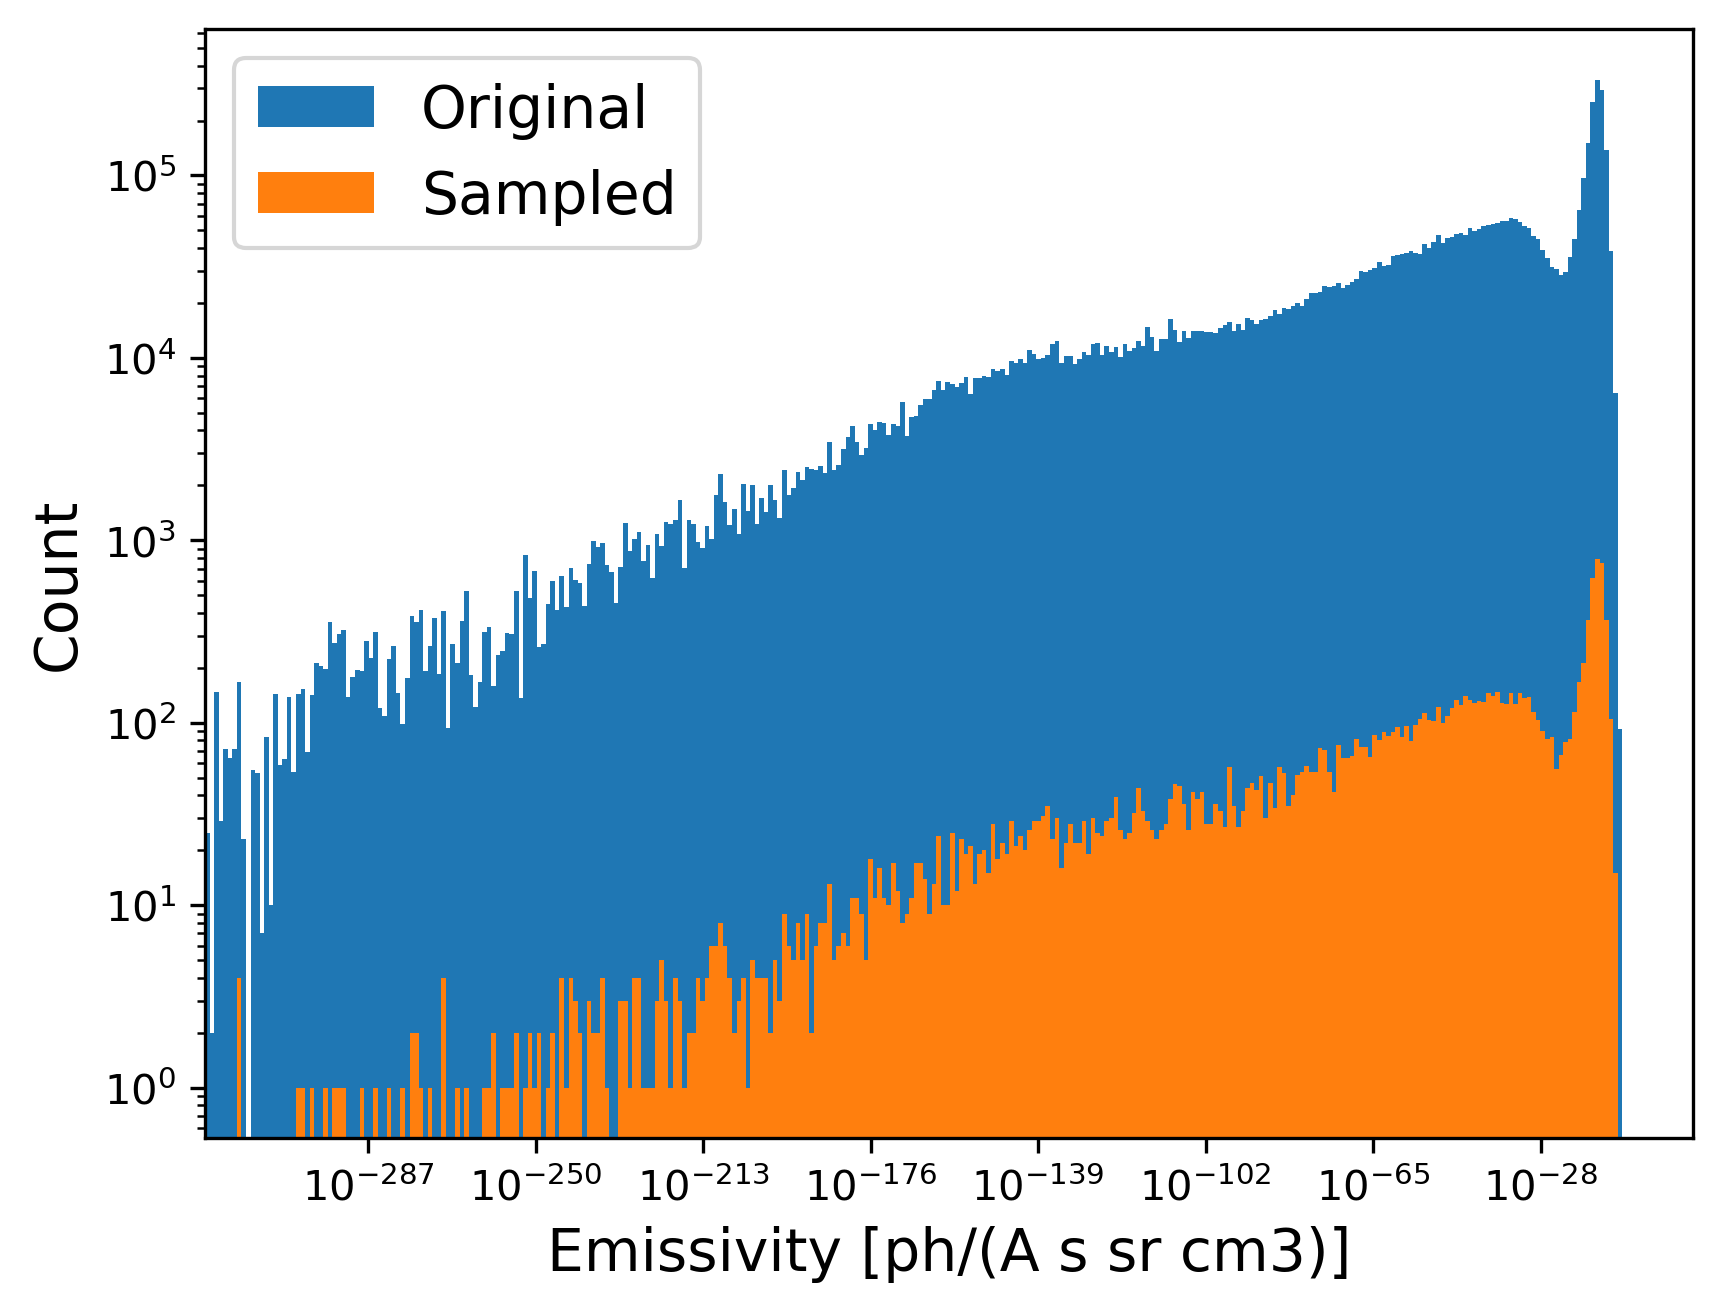

In [127]:
plt.figure(dpi=300)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Count", size=14)
plt.xlabel("Emissivity [ph/(A s sr cm3)]", size=14)
plt.hist(emissivity_cylinder.value, bins=bins, label="Original")
plt.hist(sampled_emissivity.value,  bins=bins, label="Sampled")
plt.legend(fontsize=14)
plt.savefig("../visuals/emissivity_histogram_sampled.png")
plt.show()

# Integrate

In [134]:
sampled_emissivity *= (600 * u.pc).to(u.cm)
(600 * u.pc).to(u.cm)

<Quantity 1.85140655e+21 cm>

# Plot skymap of results

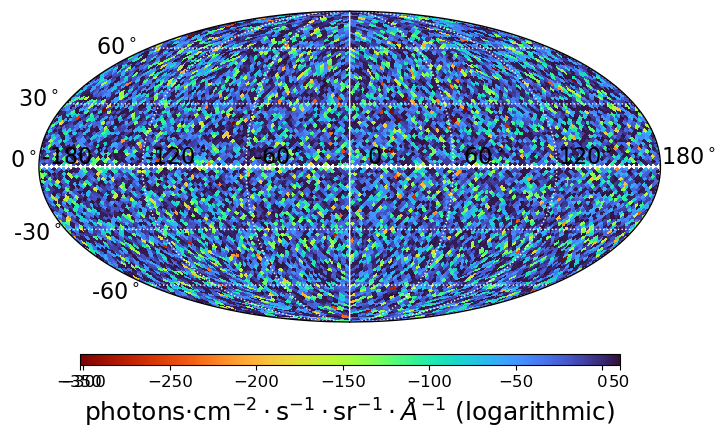

In [133]:
def create_skymap2(signal, signal_unit):
    
    theta, phi = hp.pix2ang(NSIDE, np.arange(len(signal)))
    # Convert theta to latitude in degrees
    latitude = np.degrees(np.pi / 2 - theta)
    
    # Create a mask for latitudes between -27 and 27 degrees
    # mask = (latitude >= -25) & (latitude <= 25)
    mask = (latitude >= 0) & (latitude <= 0)
    
    # Mask the data
    signal_plot = signal.copy()
    signal_plot[mask] = np.nan

    signal_plot = np.log10(signal_plot.value)
    min_value = np.nanmin(signal_plot)
    max_value = np.nanmax(signal_plot)
    
    f1 = plt.figure(figsize=(7.5,4.5), dpi=100)

    hp.mollview(signal_plot, 
                title="", 
                rot=(0,0,0),
                cmap='turbo_r', 
                fig=f1, 
                unit="",
                min = min_value,#min_value.value,#1,#np.min(f_aqn[f_aqn!=-1*f_aqn.unit]).value,
                max = max_value,#np.nanmax(signal).value,
                badcolor="white", cbar=False)
    #hp.graticule(dmer=360,dpar=360,alpha=0)  
    hp.graticule(dmer=60,dpar=30, alpha=1, color="white", linewidth=10)
    longitude_labels = [-180,-120,-60,0,60,120,180]
    label_size = 16
    for i in range(len(longitude_labels)):
        plt.text((-2.7+i)*0.66,0.02,str(longitude_labels[i])+"$^\circ$",size=16,horizontalalignment="center")

    latitude_labels = [-90,-60,-30,0,30,60,90]
    plt.text(-2.01,-0.47,"-30$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-2.1,0,"0$^\circ$",size=label_size,horizontalalignment="center")
    plt.text(-2,0.39,"30$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-1.5,0.73,"60$^\circ$",size=label_size,horizontalalignment="center") 
    plt.text(-1.51,-0.85,"-60$^\circ$",size=label_size,horizontalalignment="center") 


    # Customize the colorbar
    fig = plt.gcf()
    ax = fig.axes[0]  # Get the axis of the mollview plot
    im = ax.get_images()[0]
    
    # Add a new colorbar
    cbar = fig.colorbar(im, orientation='horizontal', pad=0.075, aspect=50, shrink=0.75)
    cbar.set_label(r'photons$\cdot$cm$^{-2}\cdot$s$^{-1}\cdot$sr$^{-1}\cdot\AA^{-1}$ (logarithmic)', size=18)

    
    # Adjust the size of the colorbar
    cbar.ax.tick_params(labelsize=12)  # Adjust tick size
    # cbar.ax.set_xlabel('Unit', size=16) 
    # plt.savefig("simulated_signal_sky_map.png", bbox_inches = "tight")
    plt.savefig("skymap_2.png", bbox_inches = "tight")

    # plt.savefig("simulated_signal_sky_map.pdf", bbox_inches = "tight")

    plt.show()

create_skymap2(sampled_emissivity, sampled_emissivity.unit)

In [87]:
print(f_aqn)

[19.04437218 19.04437218 19.04437218 ... 19.04437218 19.04437218
 19.04437218] ph / (Angstrom s sr cm2)


In [83]:
print(f_aqn)

[4.14328156 4.14328156 4.14328156 ... 4.14328156 4.14328156 4.14328156] ph / (Angstrom s sr cm2)
